In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
tf.__version__

'2.10.0'

In [12]:
(X_train,y_train),(_,_) = tf.keras.datasets.mnist.load_data() ##NN will learn to create image by own by training datasets
##We want only the training dataset, not going to compare or predict so no need to have test set

In [13]:
X_train.shape
##28X28 = 784 pixels, therefore 784 inputs for GAN

(60000, 28, 28)

8


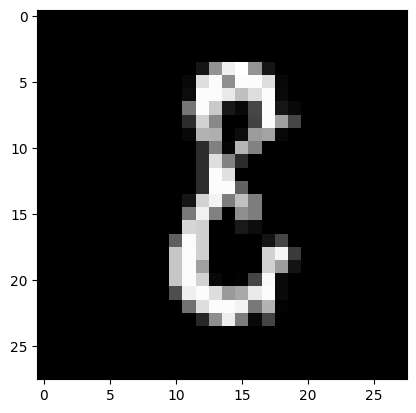

In [14]:
i = np.random.randint(0,60000)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

In [ ]:
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [21]:
X_train.shape

(60000, 28, 28, 1)

In [32]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [31]:
X_train = (X_train-127.5)/127.5 ##This normalization gives results between -1 to 1, 
                ## the reason is GAN gives better results with this type of normalization

In [30]:
255/2

127.5

In [ ]:
buffersize = 60000
batchsize = 256 ##Total 256 images will be passed for each batch

In [ ]:
buffersize/batchsize ##Total of 234 batches. each batch 256 images will be passes.

234.375

In [35]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffersize).batch(batchsize)

In [45]:
def build_generator():
    network = tf.keras.Sequential()
    network.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,))) ##Since no prediction no bias required, default value is True
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU()) ##LeakyRelu is recommended for GAN because Relu is 0 to 1, leakyrelu 0.01x, 1
    network.add(layers.Reshape((7,7,256)))
    
    #7X7X128
    network.add(layers.Conv2DTranspose(128,(5,5),padding='same',use_bias=False)) #Conv2D decreases the dimensions where as Conv2DTranspose increses
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #14X14X64
    network.add(layers.Conv2DTranspose(64,(5,5),padding='same',strides=(2,2), use_bias=False)) #Conv2D decreases the dimensions where as Conv2DTranspose increses
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))

    network.summary()

    return network

    

In [46]:
generator = build_generator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_2 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 128)       

In [47]:
##Create random numbers as input to Generator fun
noise = tf.random.normal([1,100])


In [48]:
generated_image = generator(noise,training=False)

In [49]:
generated_image.shape

TensorShape([1, 28, 28, 1])

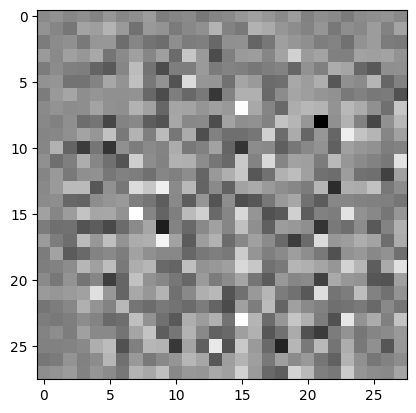

In [52]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [56]:
#Building Discriminator:

def build_discriminator():
    network = tf.keras.Sequential()

    #14X14X64
    network.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    network.summary()

    return network 




In [57]:
discriminator = build_discriminator()
discriminator

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [59]:
discriminator(generated_image,training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00165158]], dtype=float32)>

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) ##logits the values of the output layer not ready 
##the value is not probability 



In [63]:
def discriminator_loss(expected_output,fake_output):
    #1 loss for real images, 1 loss for fake images
    real_loss = cross_entropy(tf.ones_like(expected_output),expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [64]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)


In [66]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [67]:
epochs =100
noise_dim = 100
num_images_to_generate = 16

In [73]:
##Training Model - Implementation
@tf.function ##Global variable - stared
def train_steps(images):
    noise = tf.random.normal([batchsize,noise_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True) ##Setting True updating the weights

        expected_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))





In [74]:
test_images = tf.random.normal([num_images_to_generate,noise_dim])

In [75]:
test_images.shape

TensorShape([16, 100])

In [78]:
def train(dataset,epochs,test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_steps(image_batch)
        
        print('Epoch: ',epoch+1)
        generated_images = generator(test_images,training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i,:,:,0]*127.5+127.5,cmap='gray')
            plt.axis('off')
        plt.show()

Epoch:  1


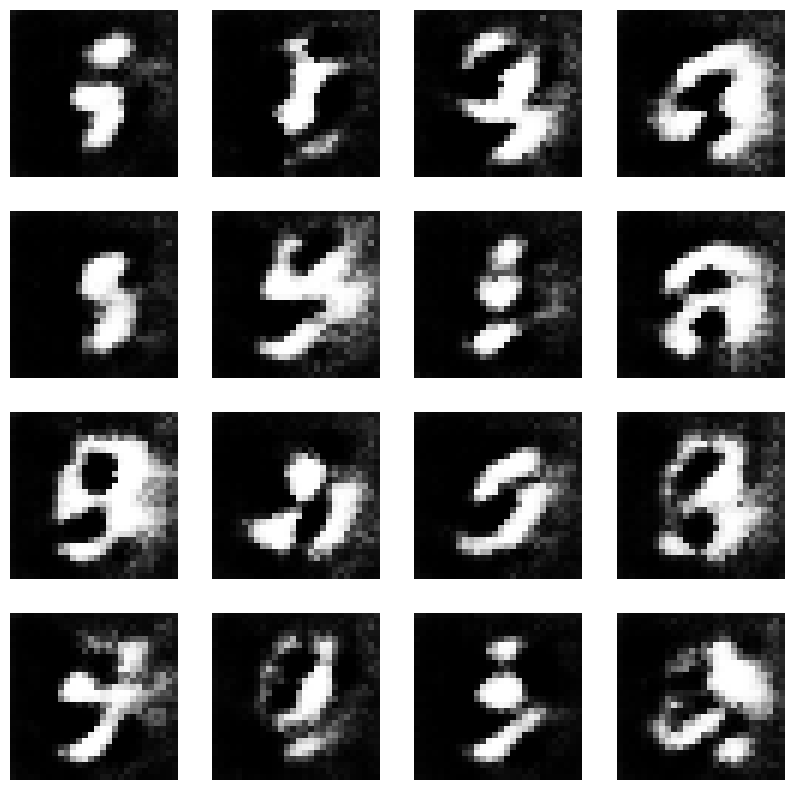

Epoch:  2


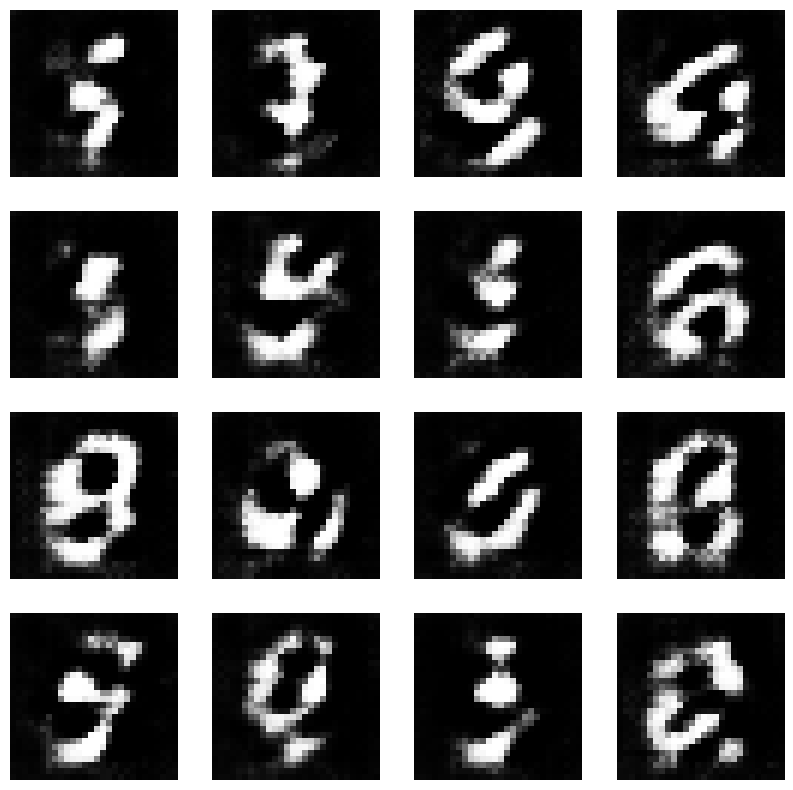

Epoch:  3


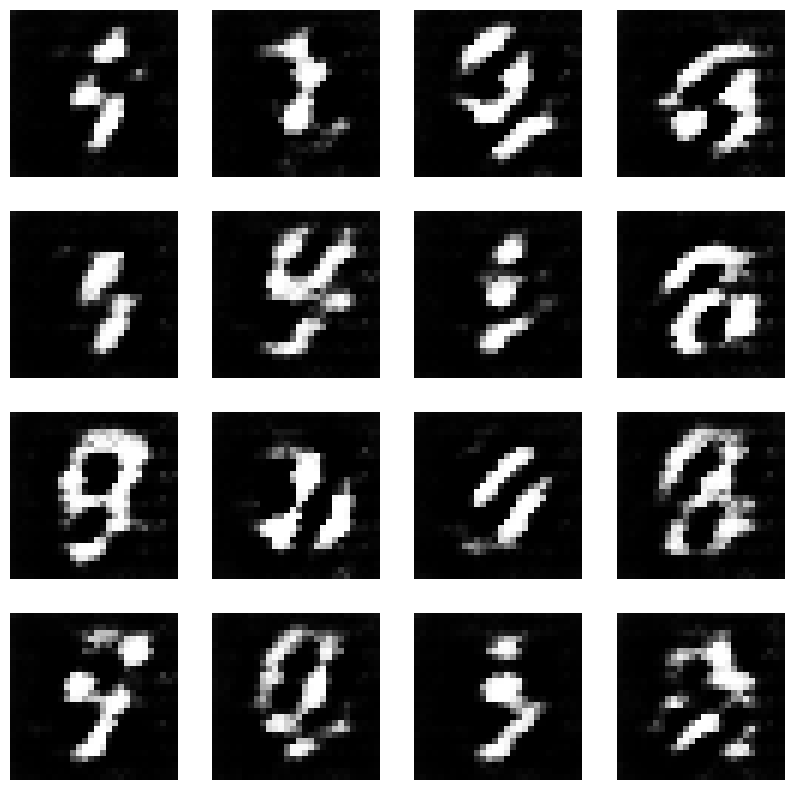

Epoch:  4


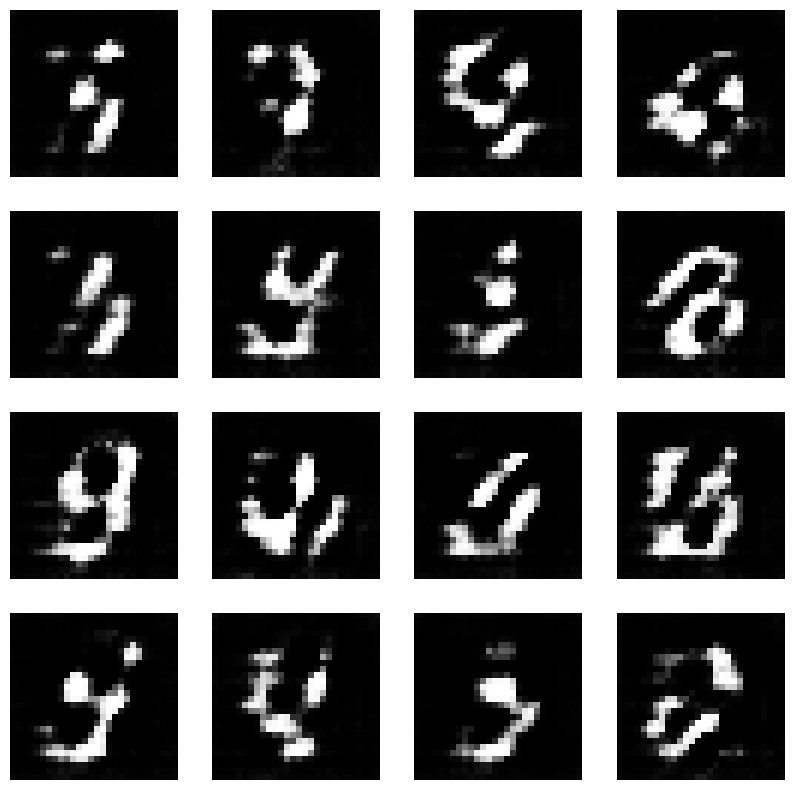

Epoch:  5


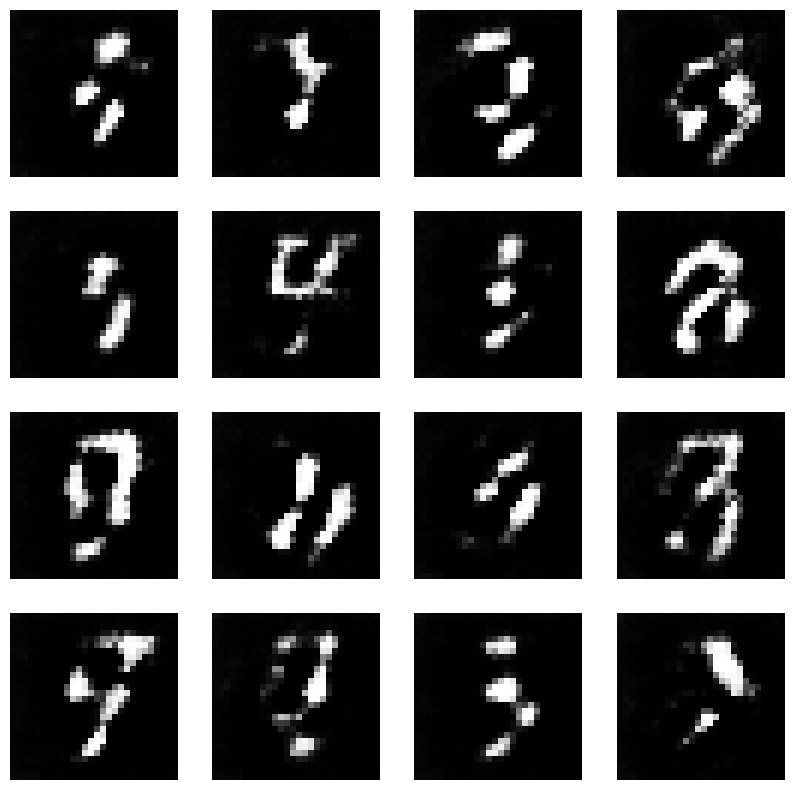

Epoch:  6


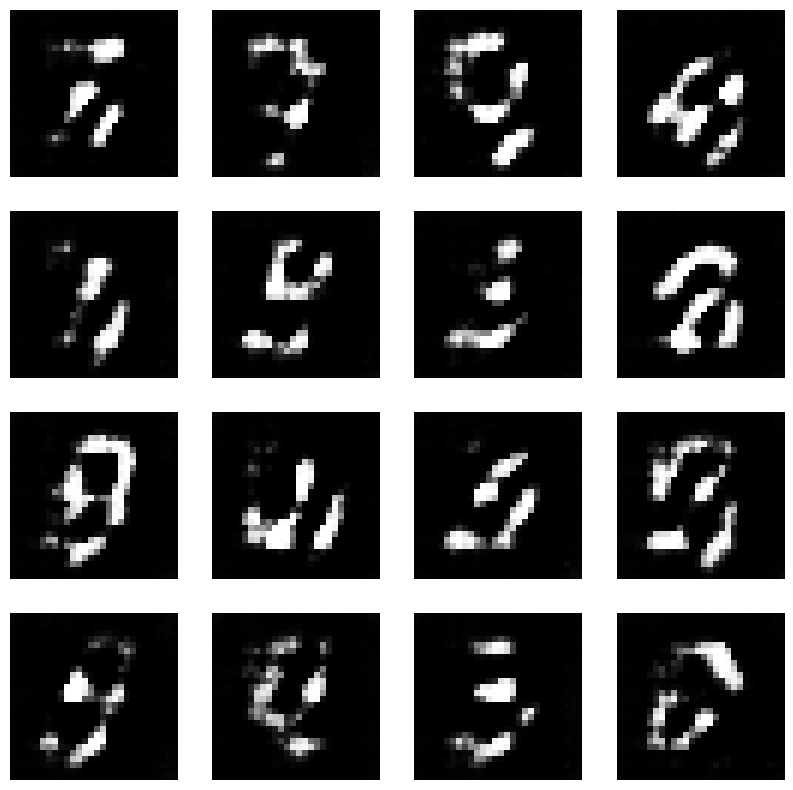

Epoch:  7


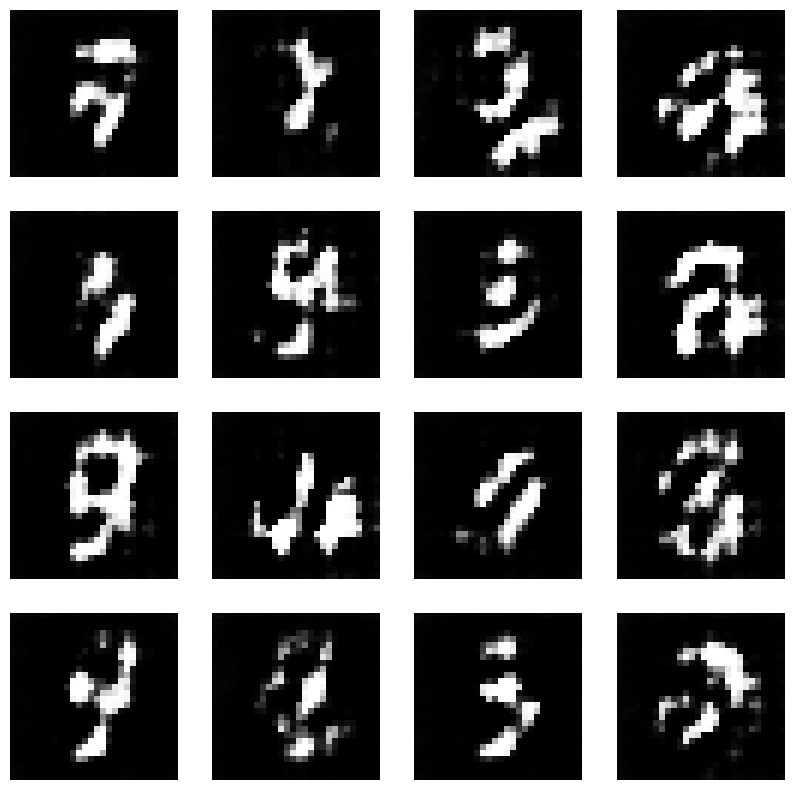

Epoch:  8


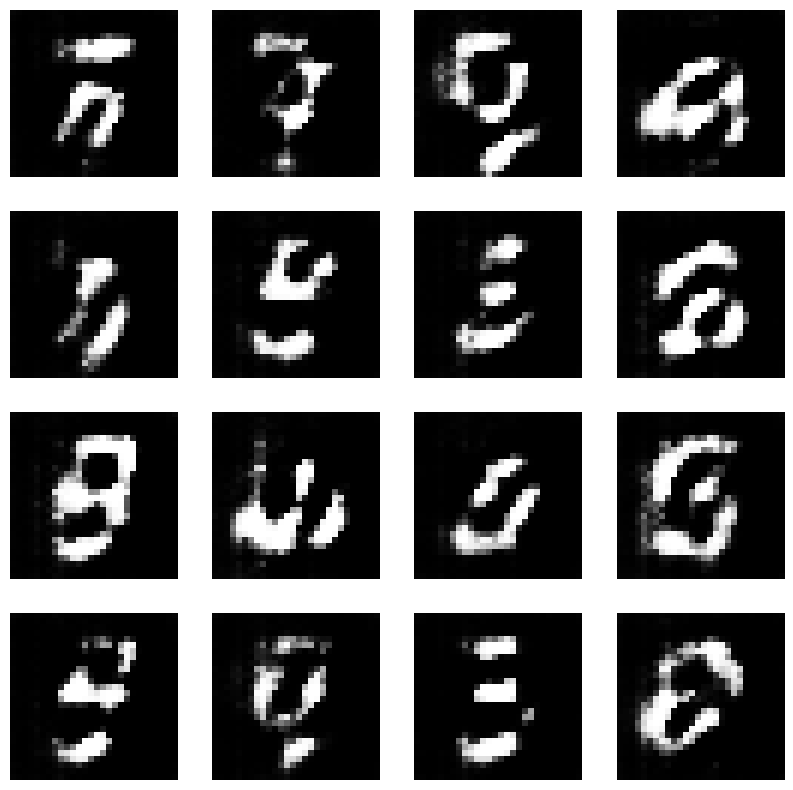

Epoch:  9


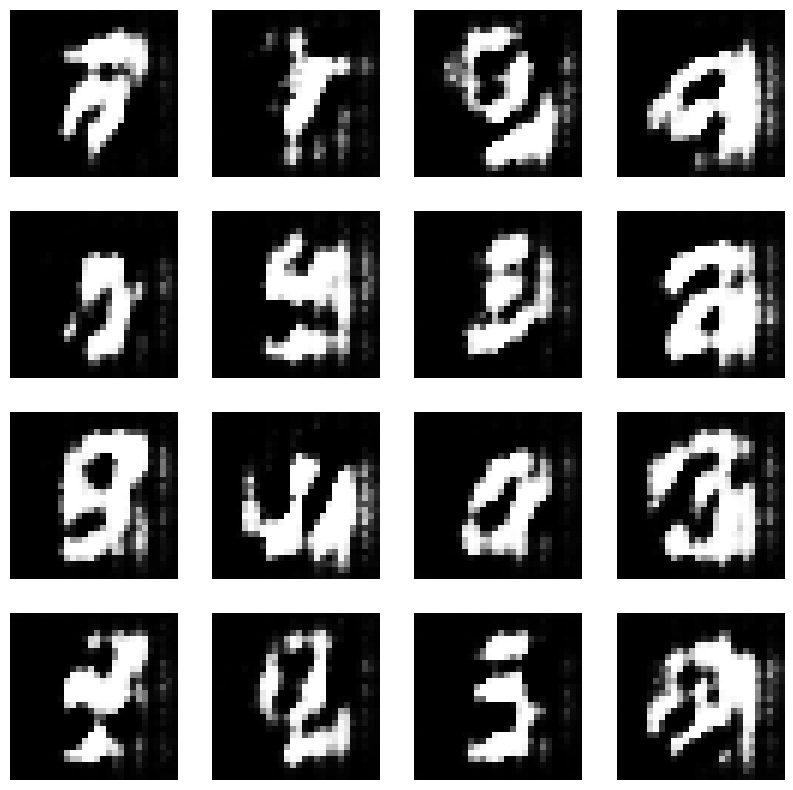

Epoch:  10


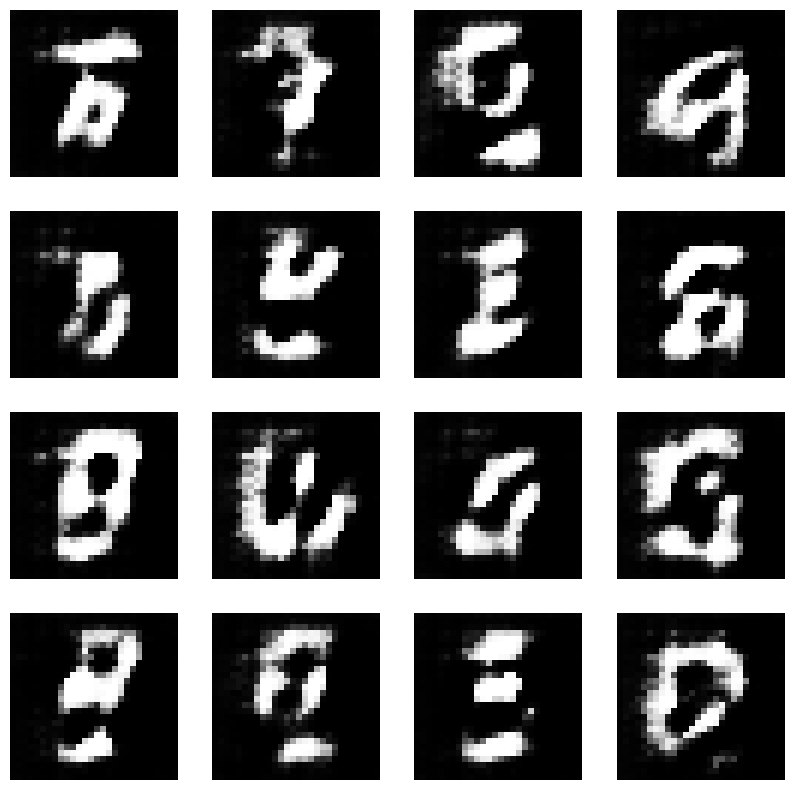

Epoch:  11


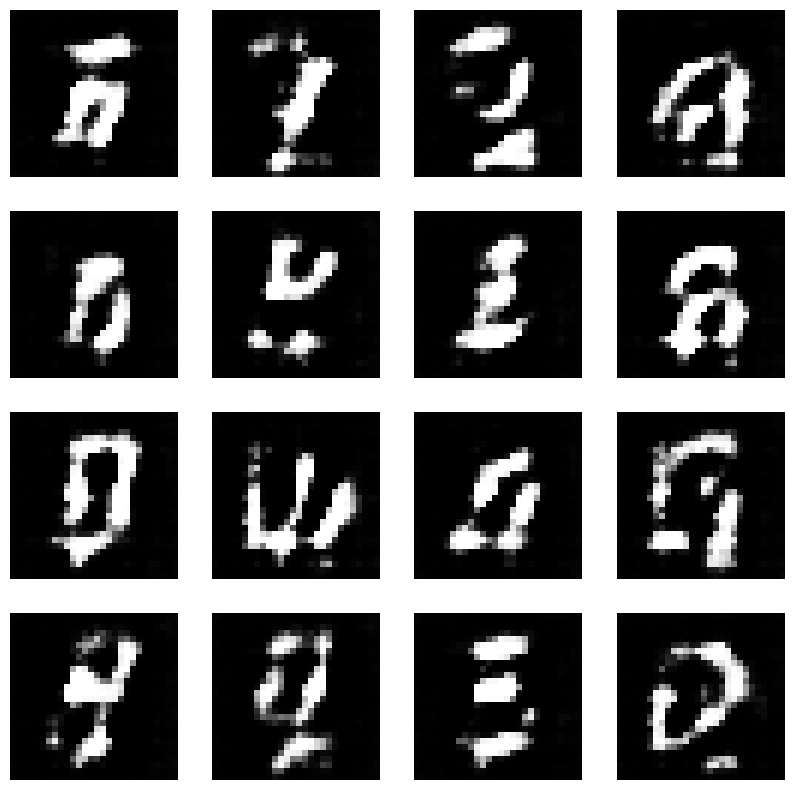

Epoch:  12


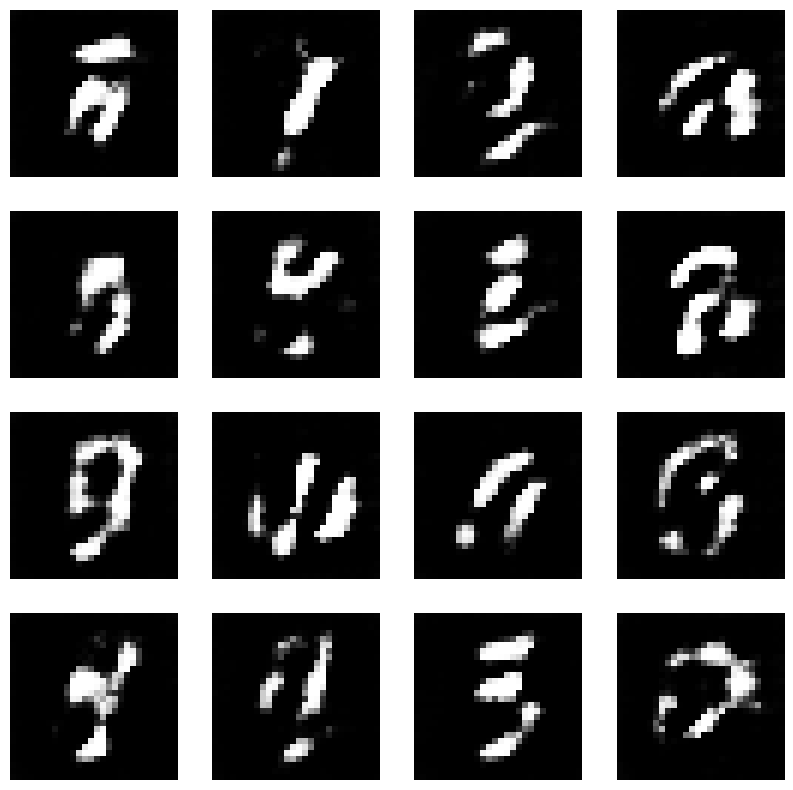

Epoch:  13


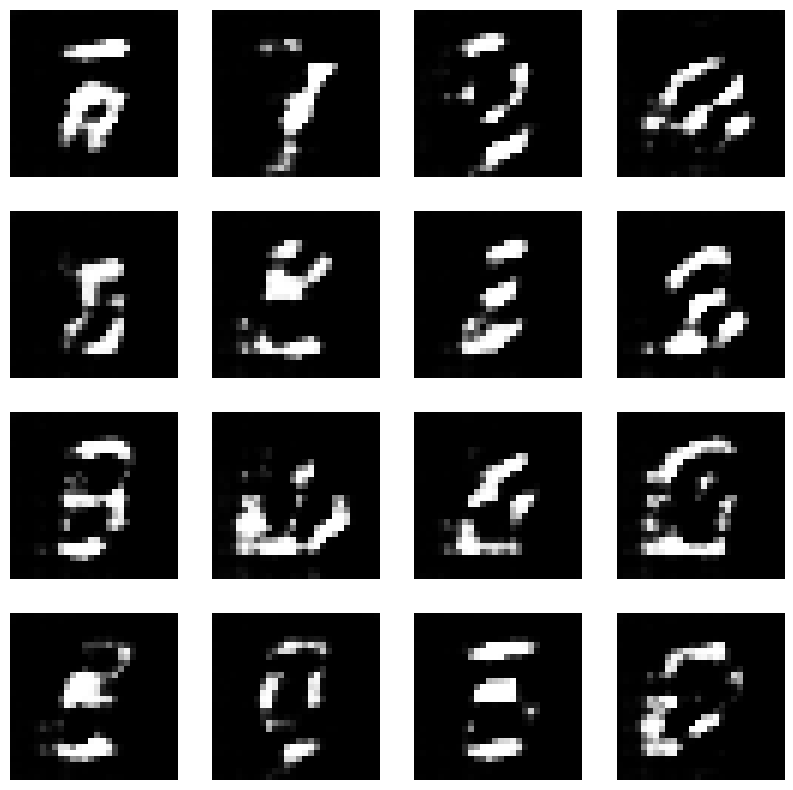

Epoch:  14


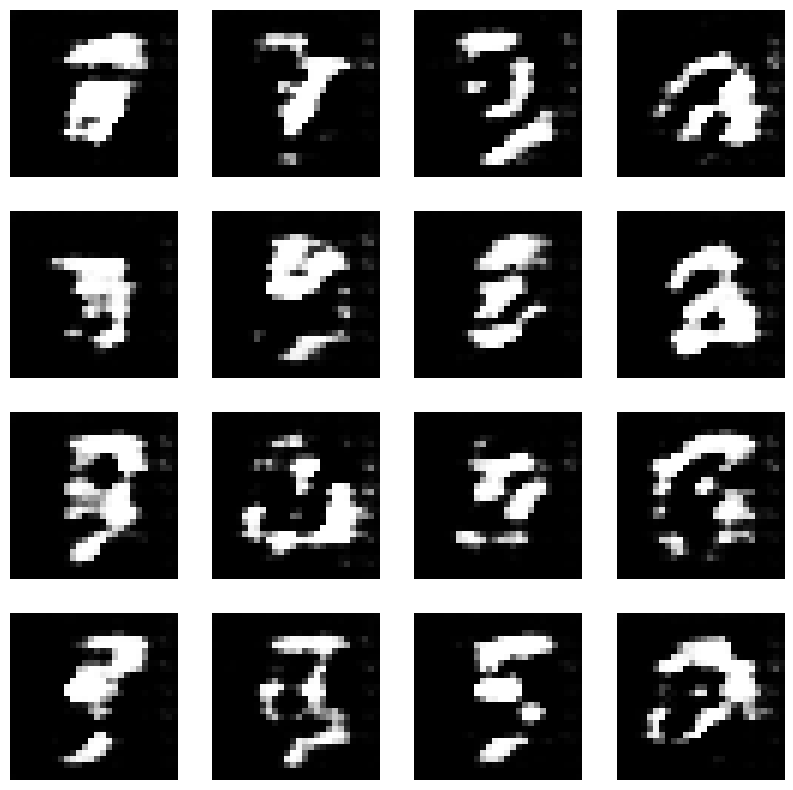

Epoch:  15


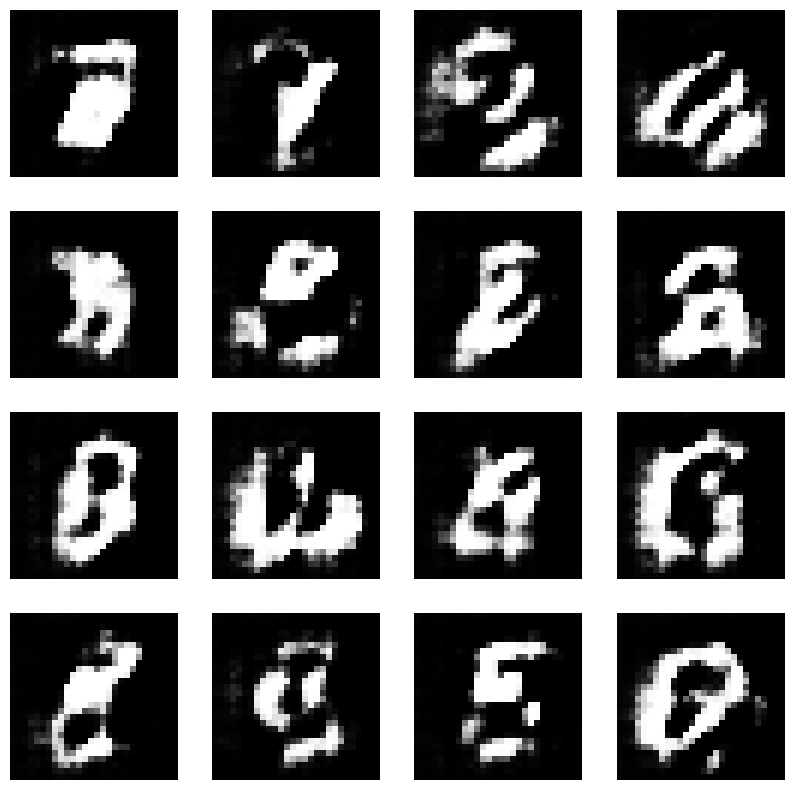

Epoch:  16


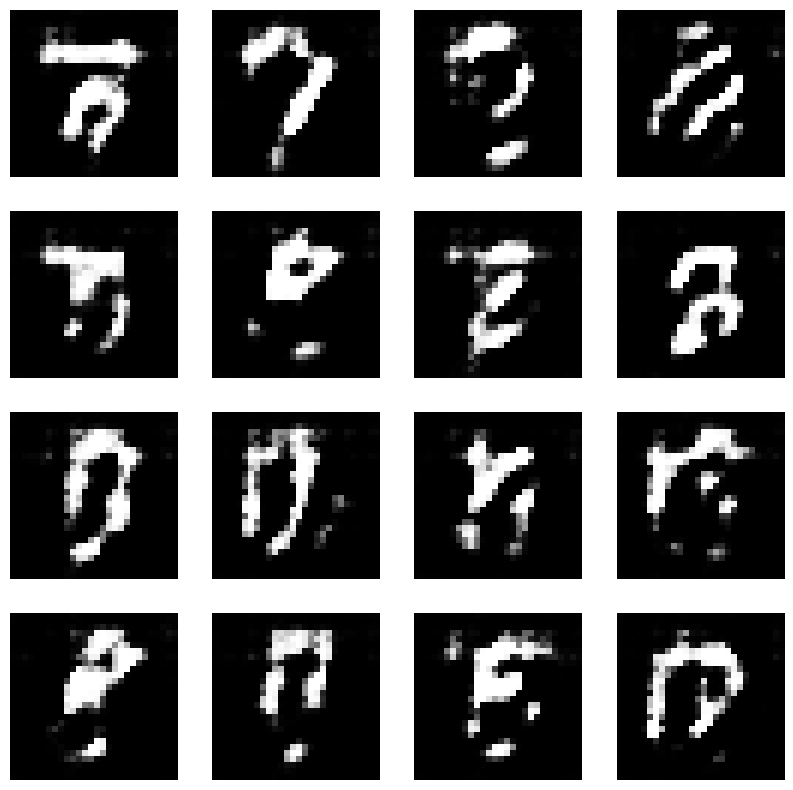

Epoch:  17


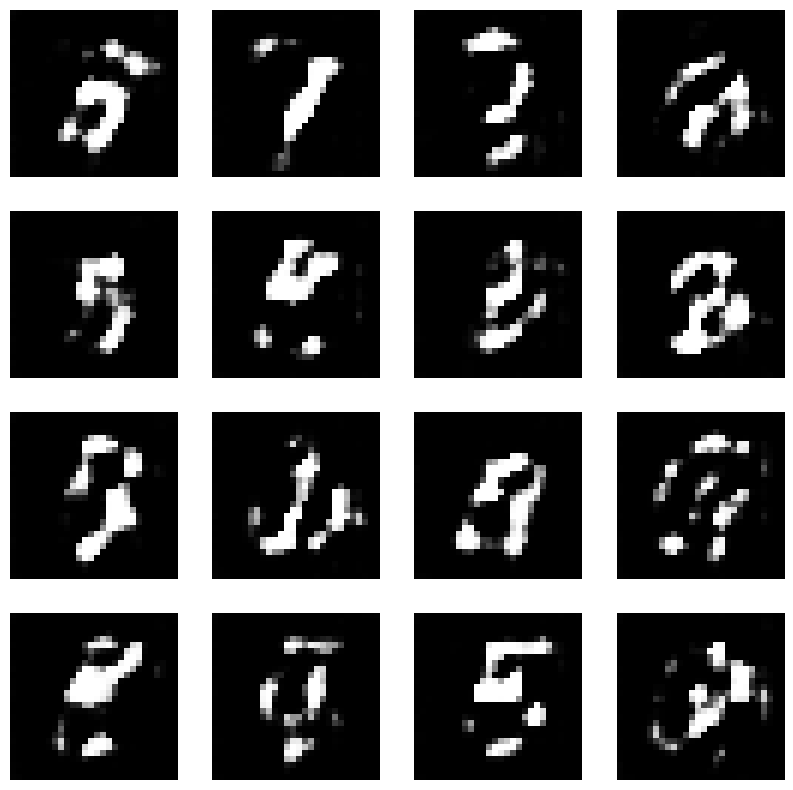

Epoch:  18


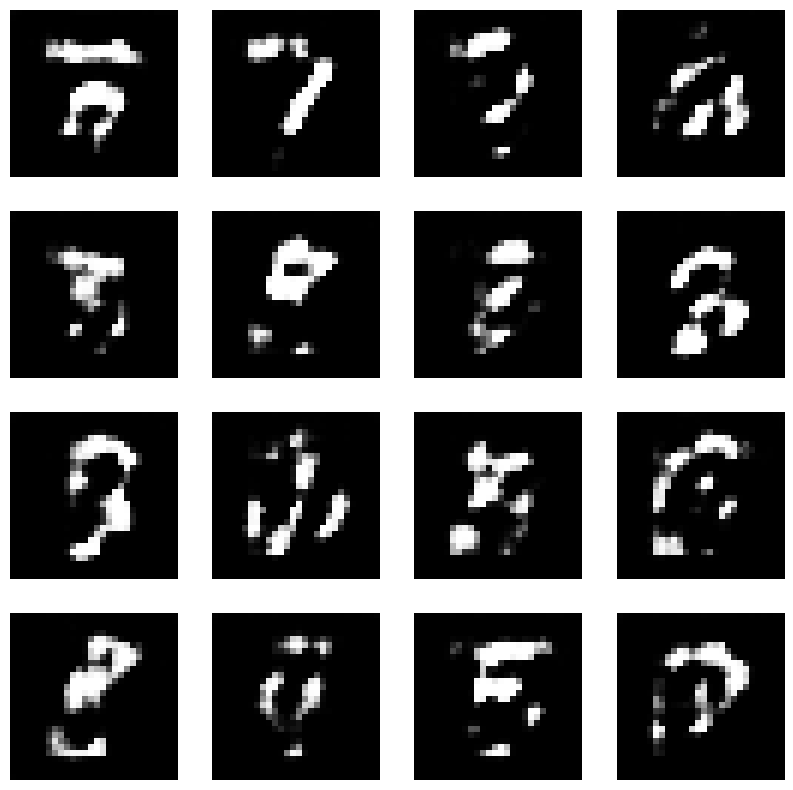

Epoch:  19


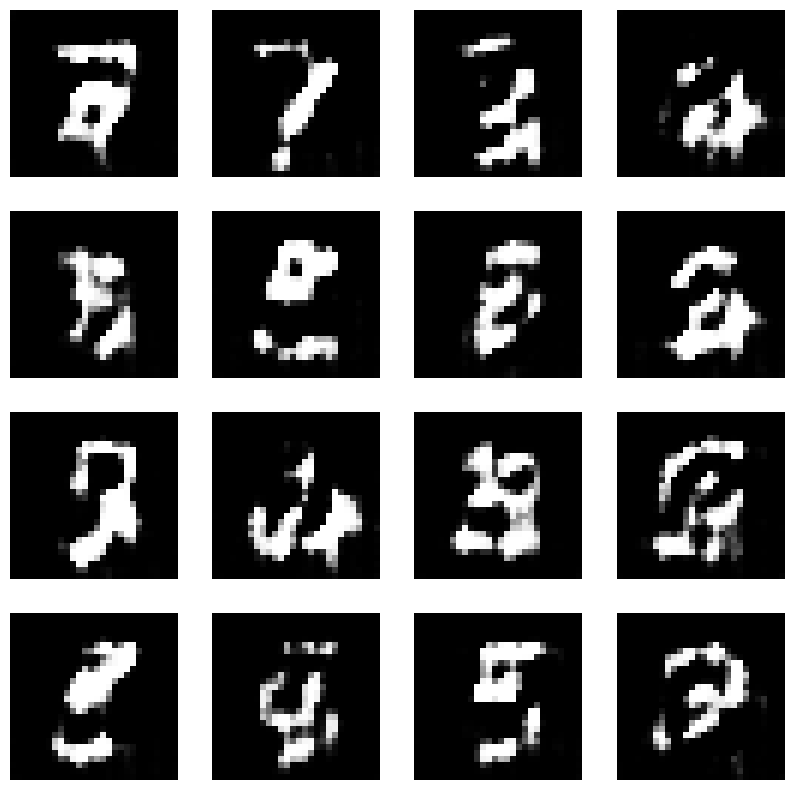

Epoch:  20


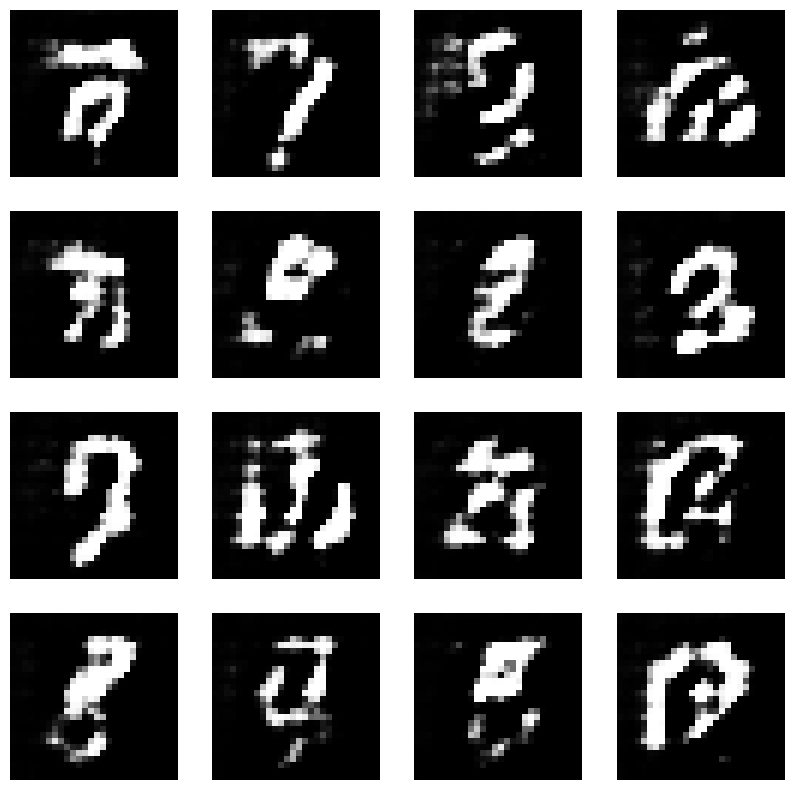

Epoch:  21


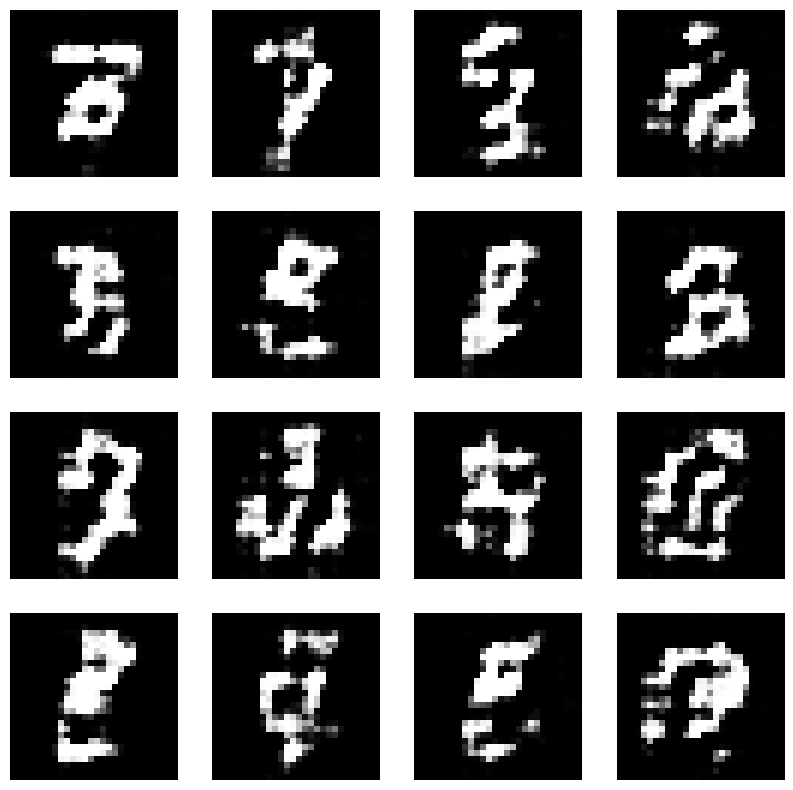

Epoch:  22


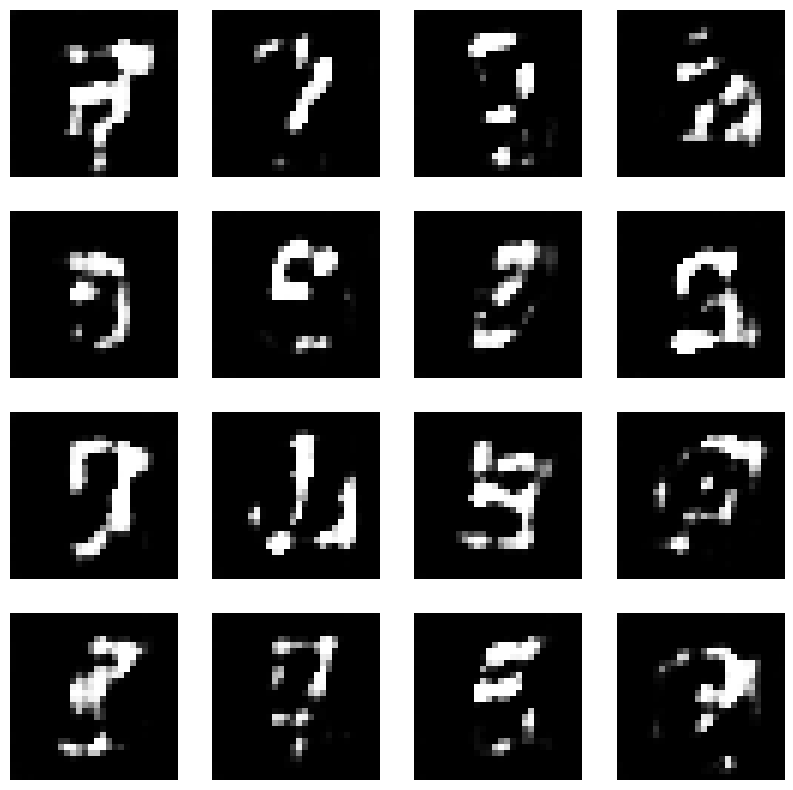

Epoch:  23


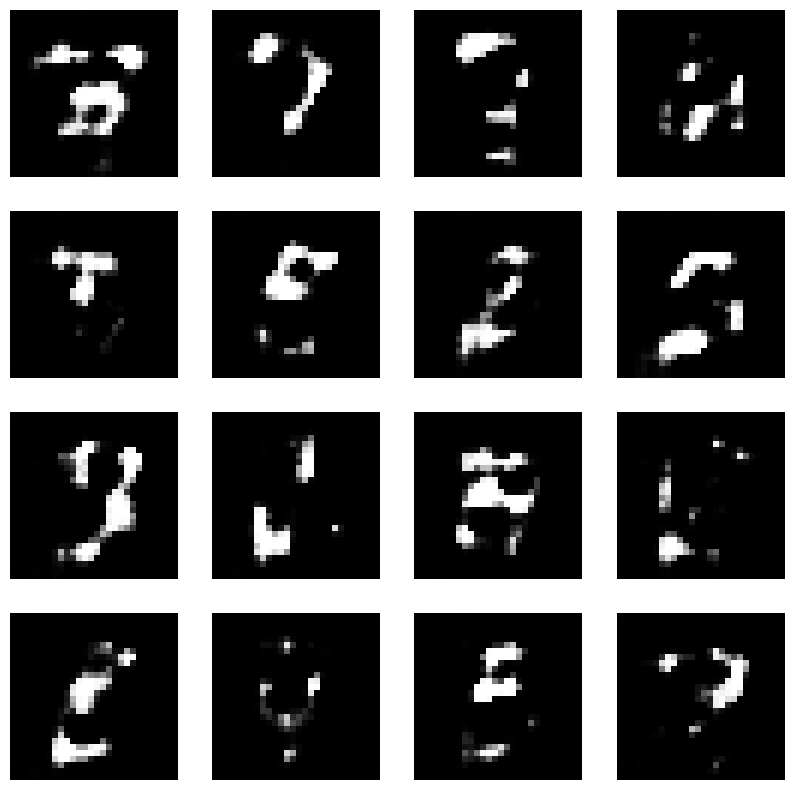

Epoch:  24


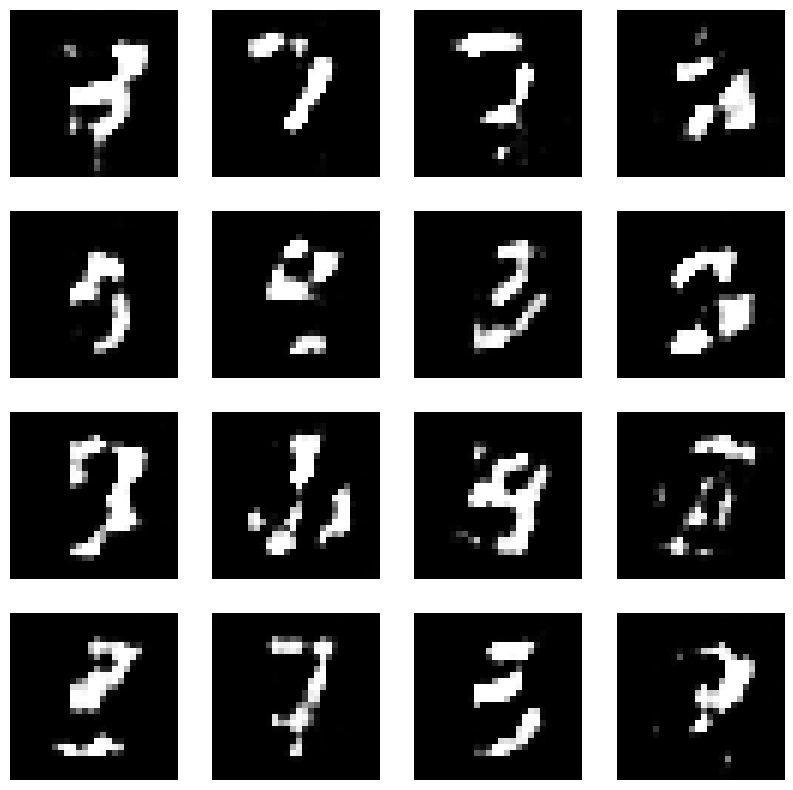

Epoch:  25


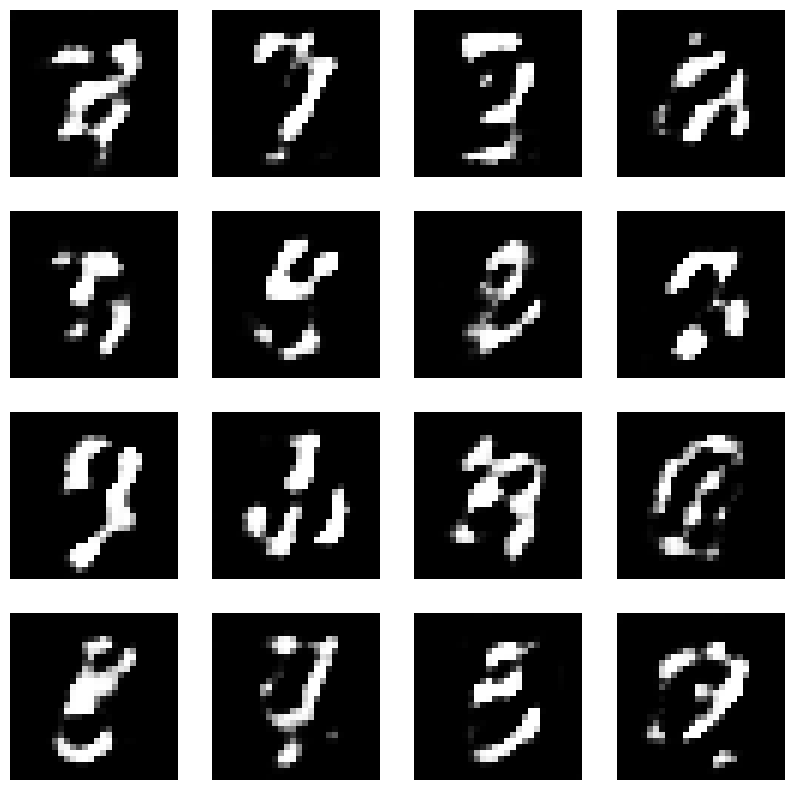

Epoch:  26


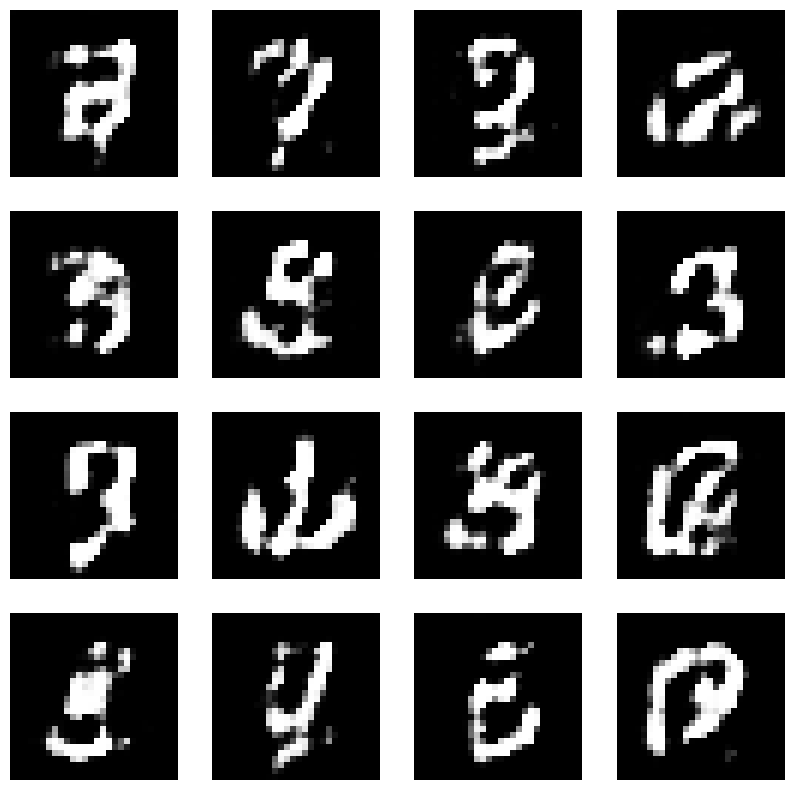

Epoch:  27


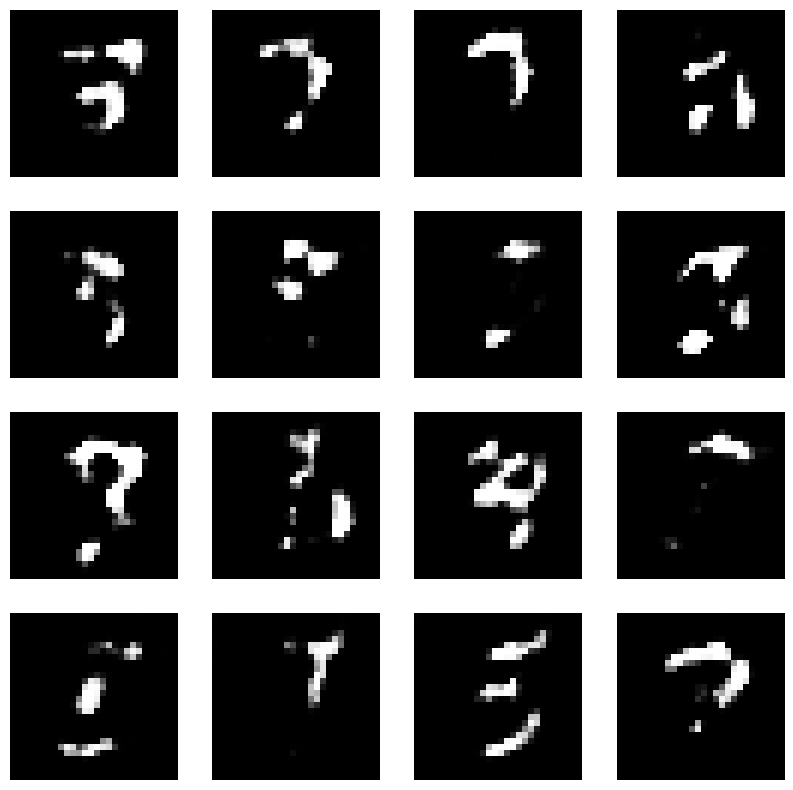

Epoch:  28


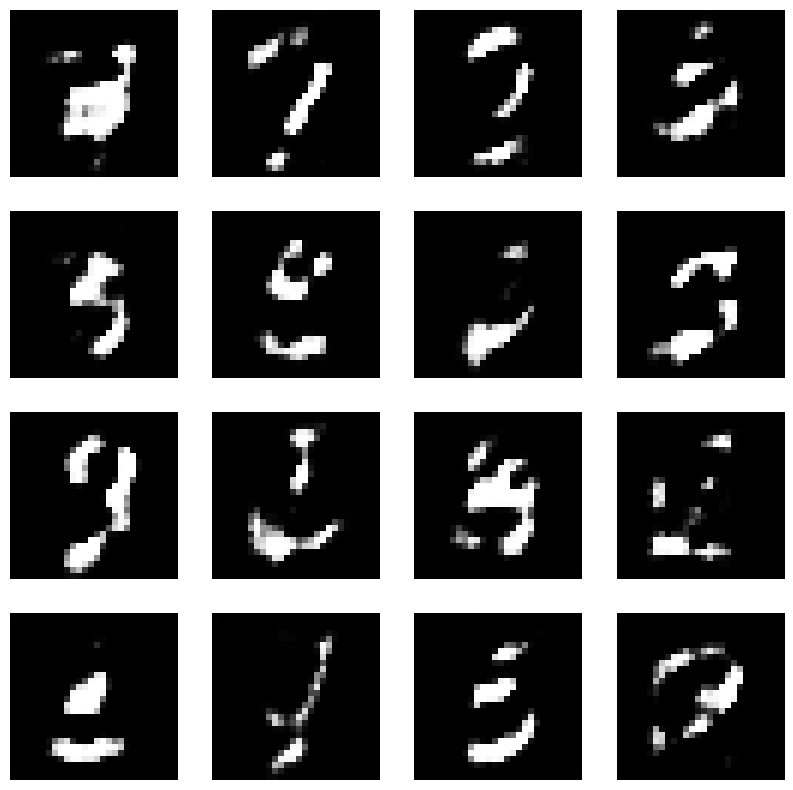

Epoch:  29


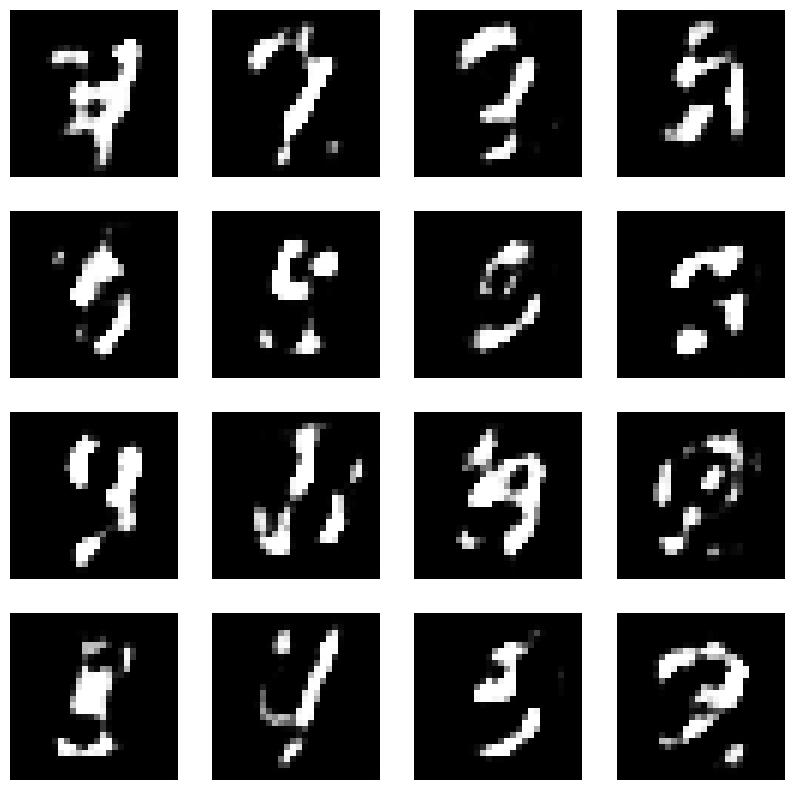

Epoch:  30


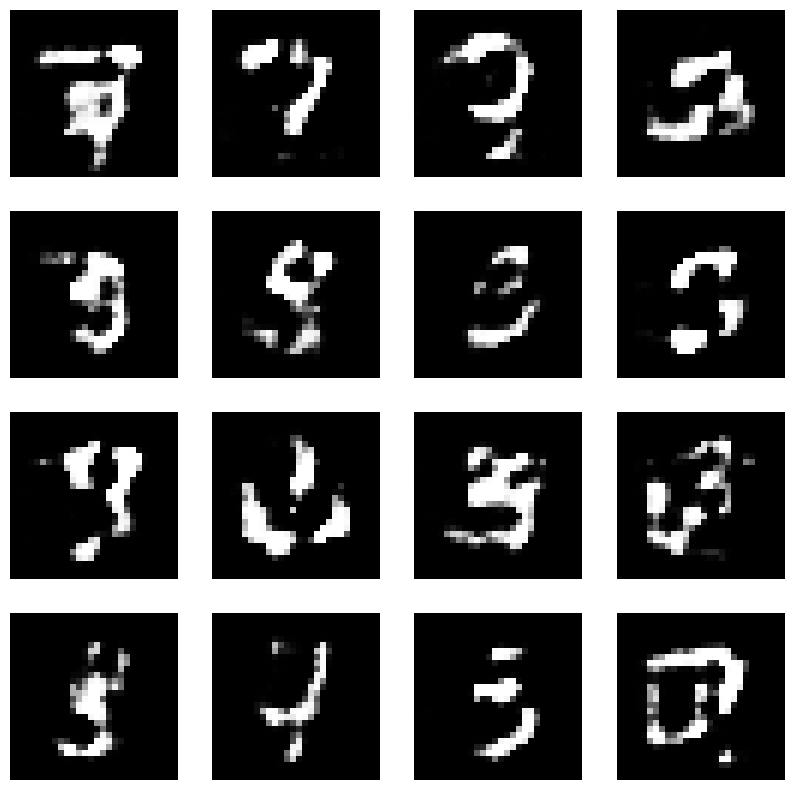

Epoch:  31


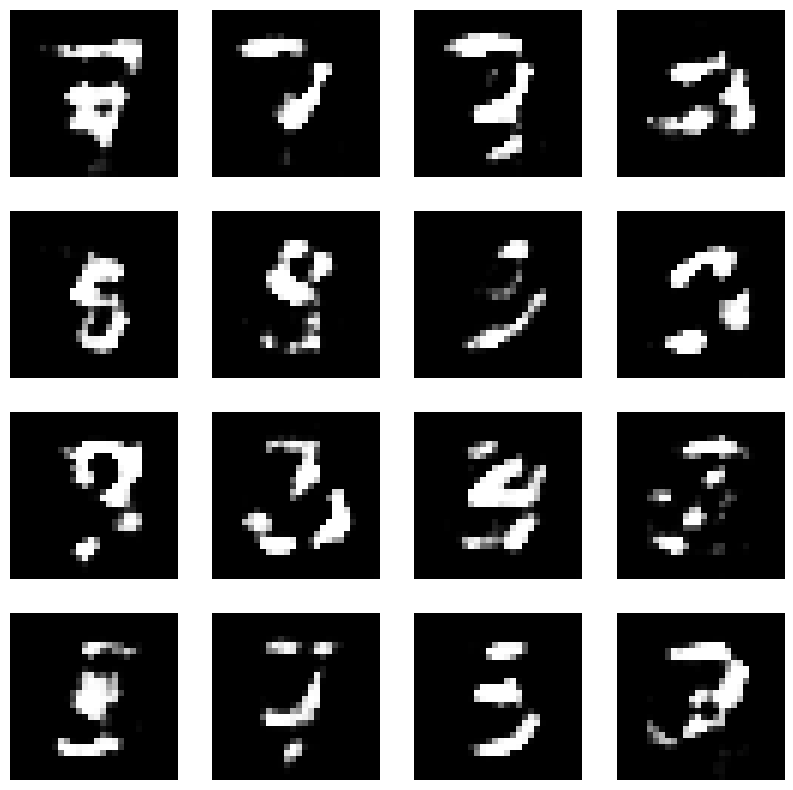

Epoch:  32


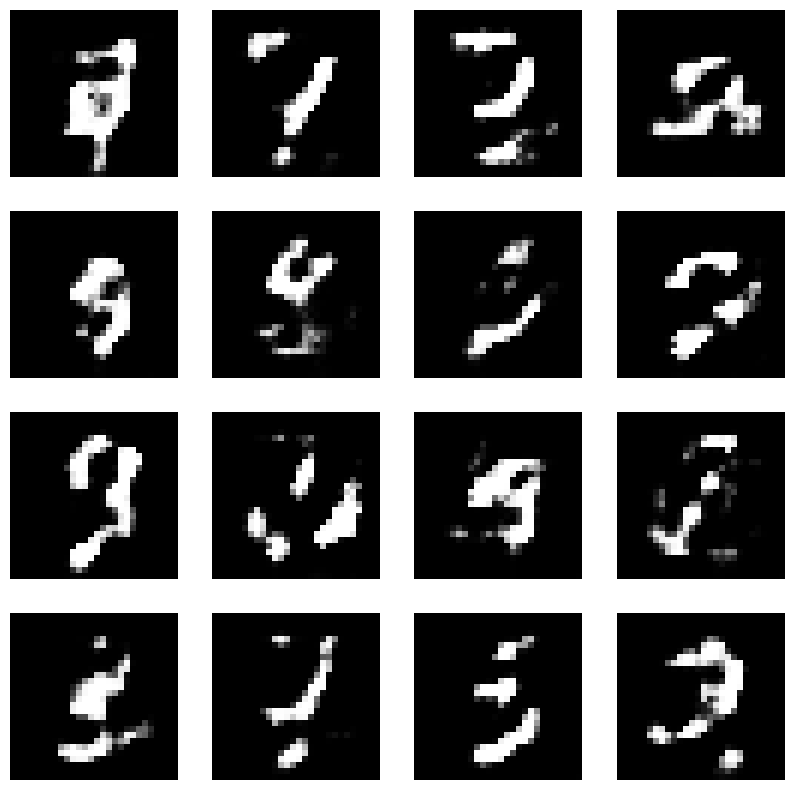

Epoch:  33


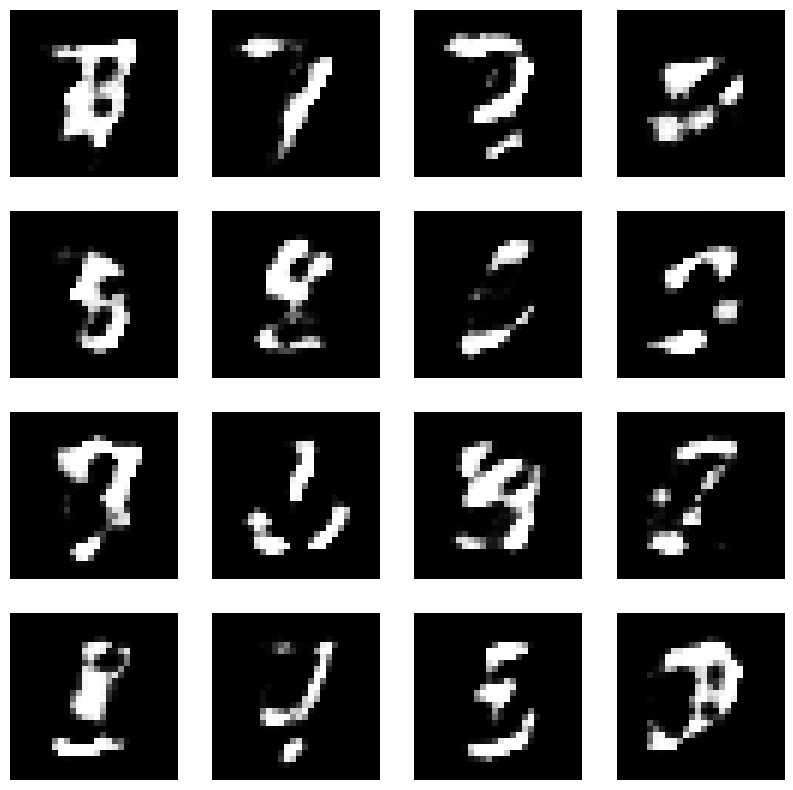

Epoch:  34


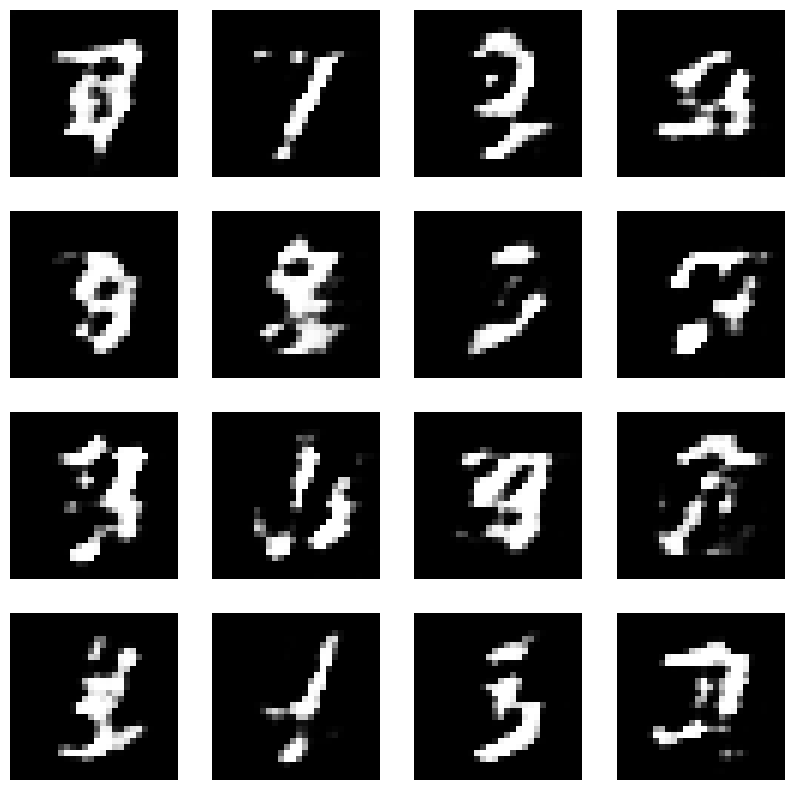

Epoch:  35


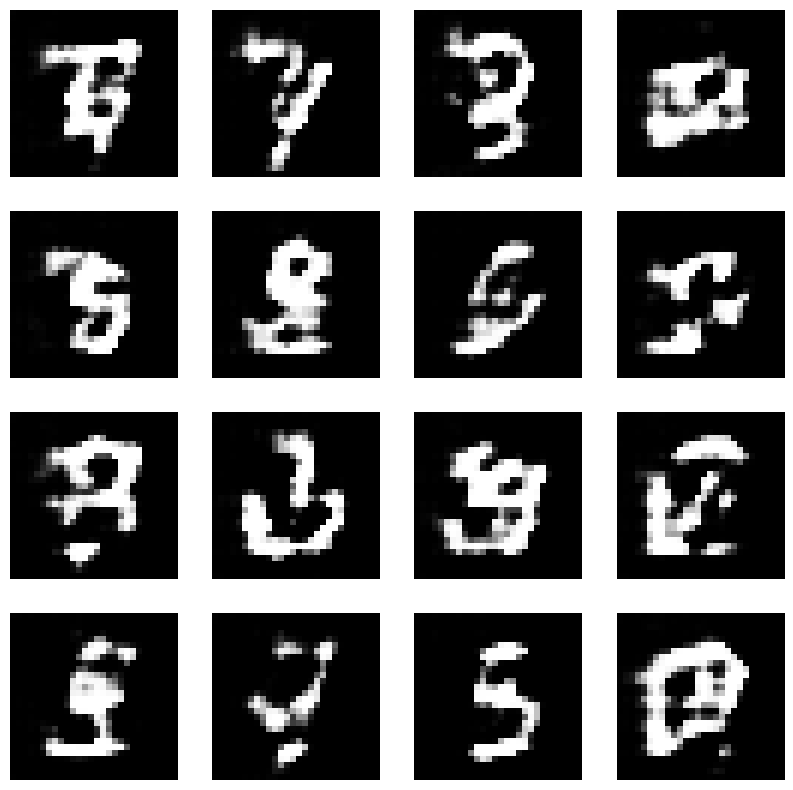

Epoch:  36


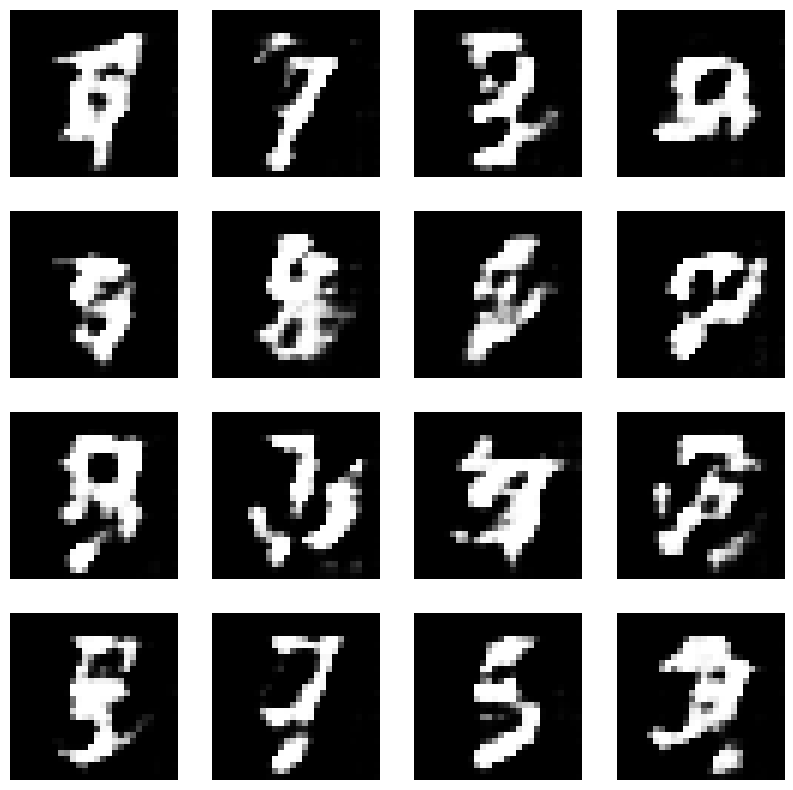

Epoch:  37


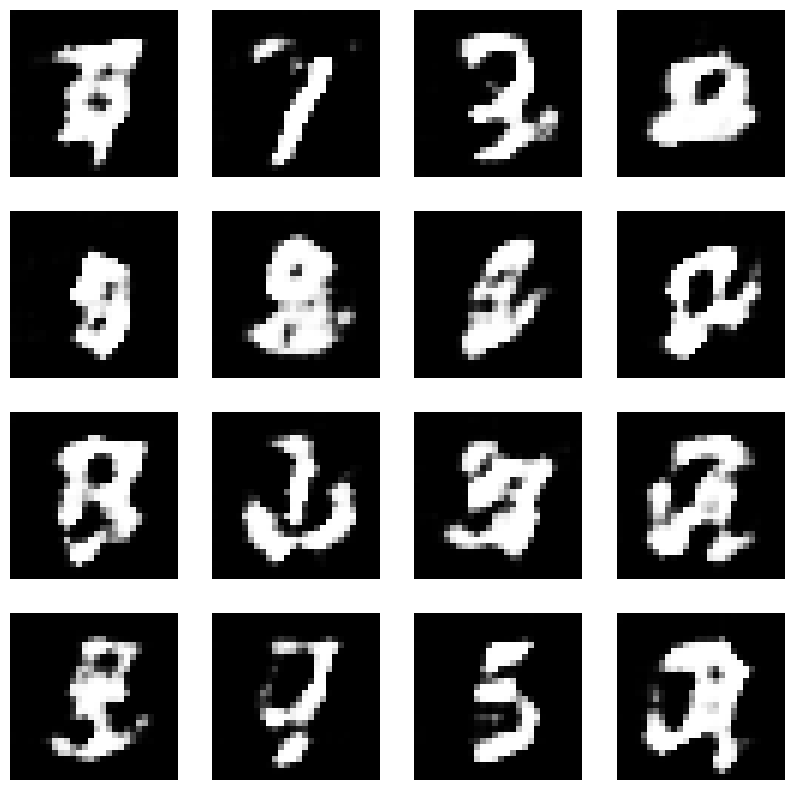

Epoch:  38


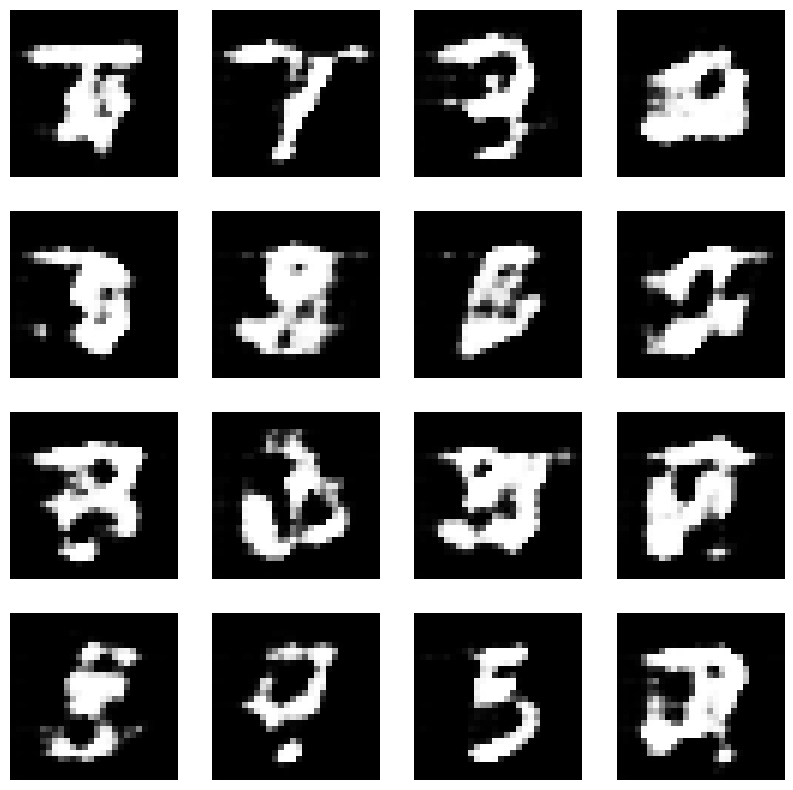

Epoch:  39


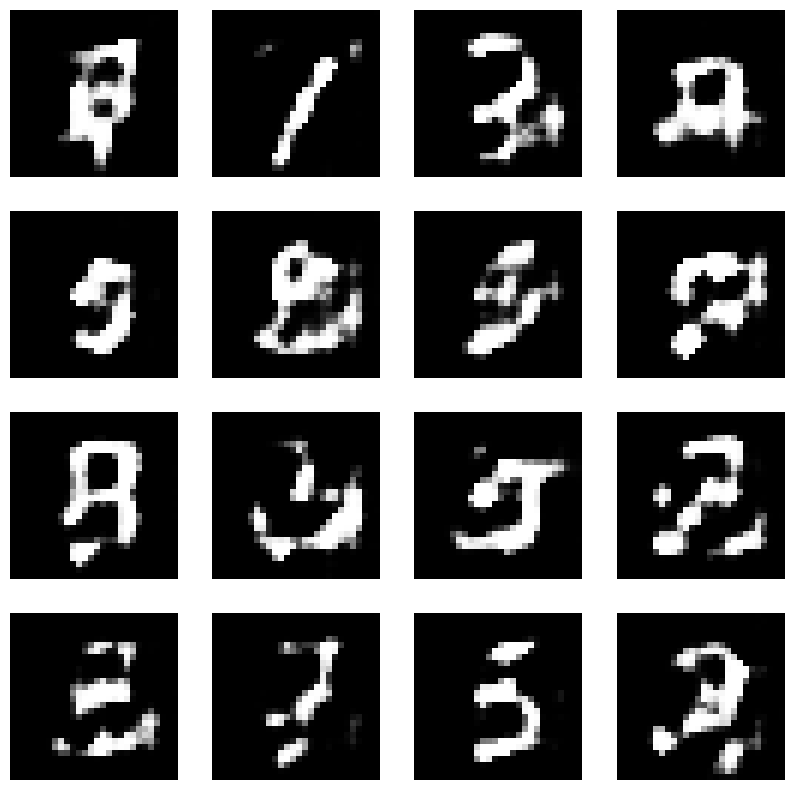

Epoch:  40


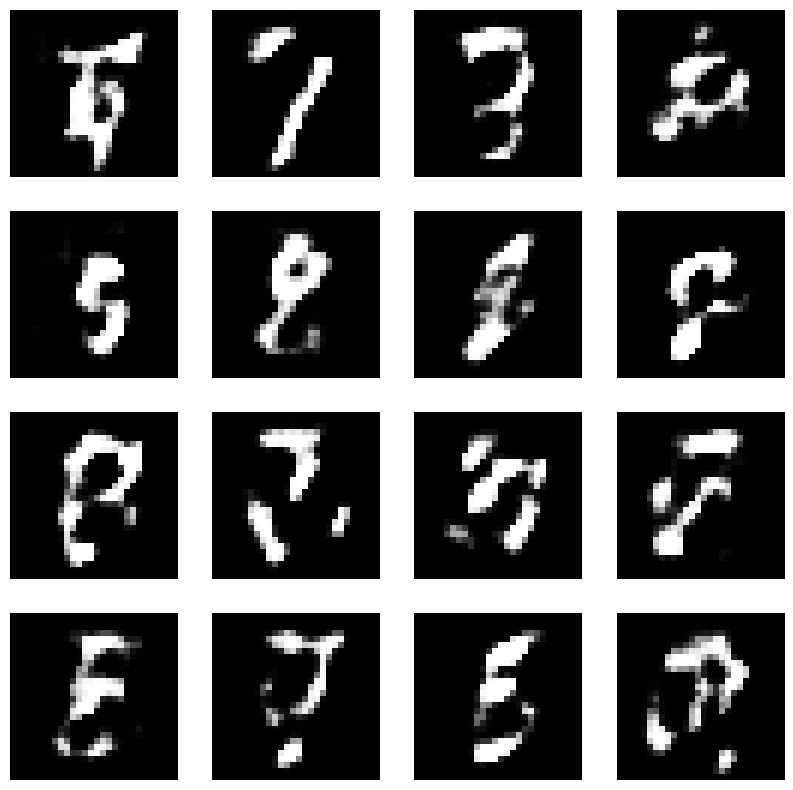

Epoch:  41


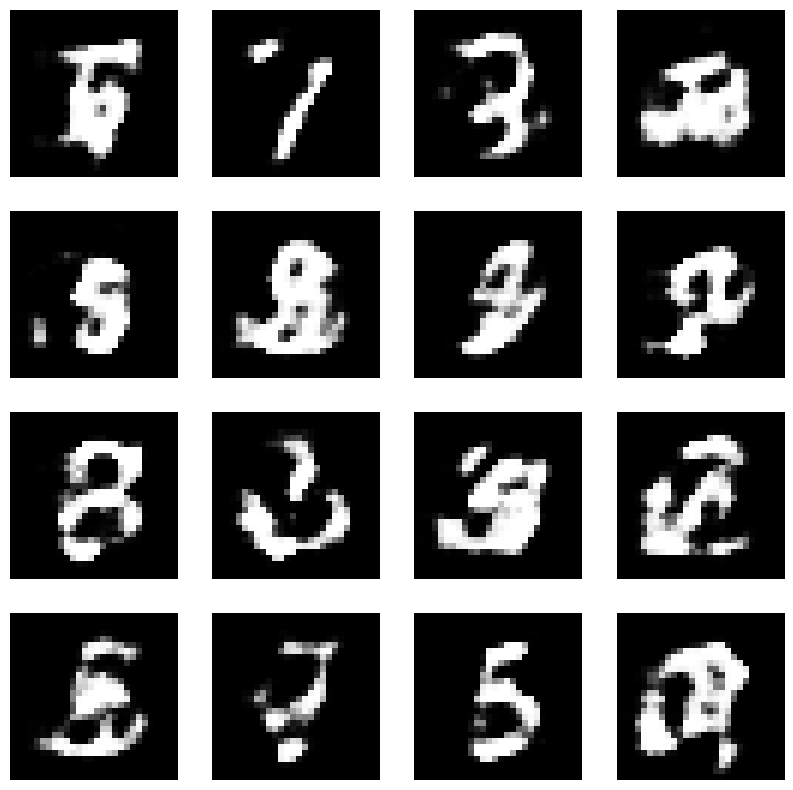

Epoch:  42


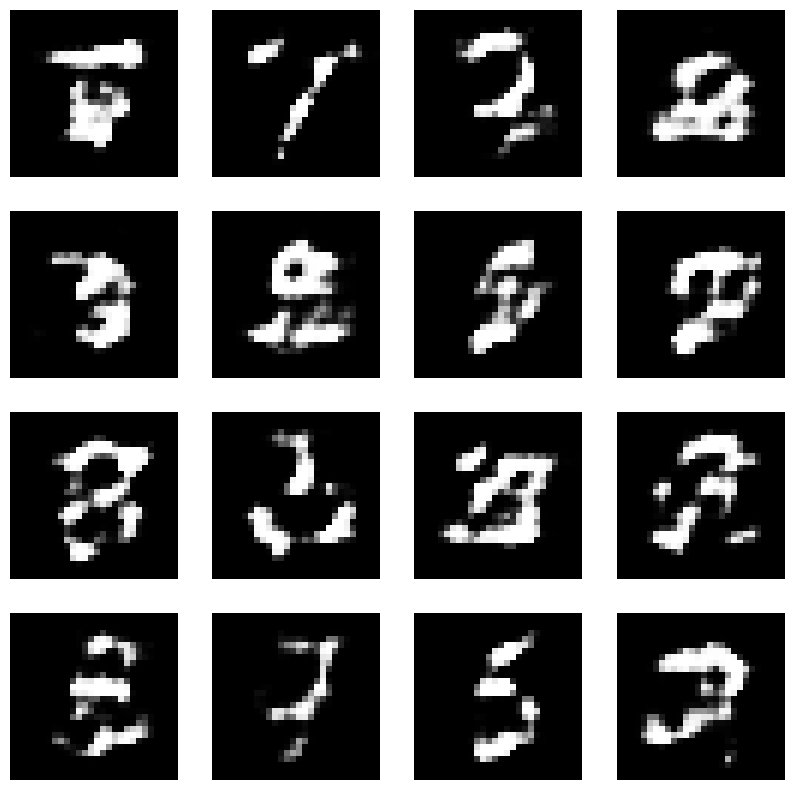

Epoch:  43


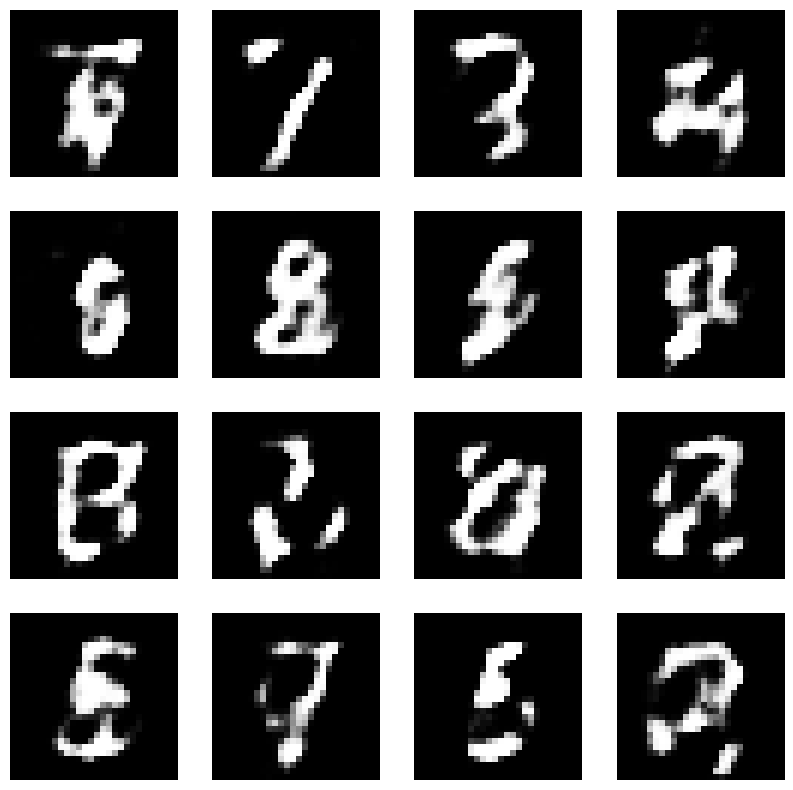

Epoch:  44


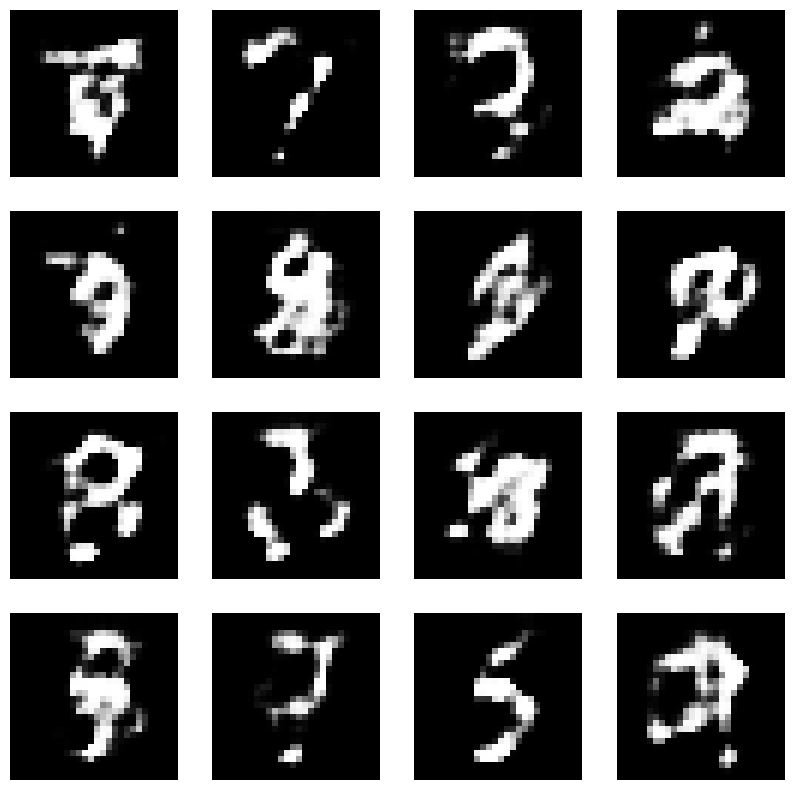

Epoch:  45


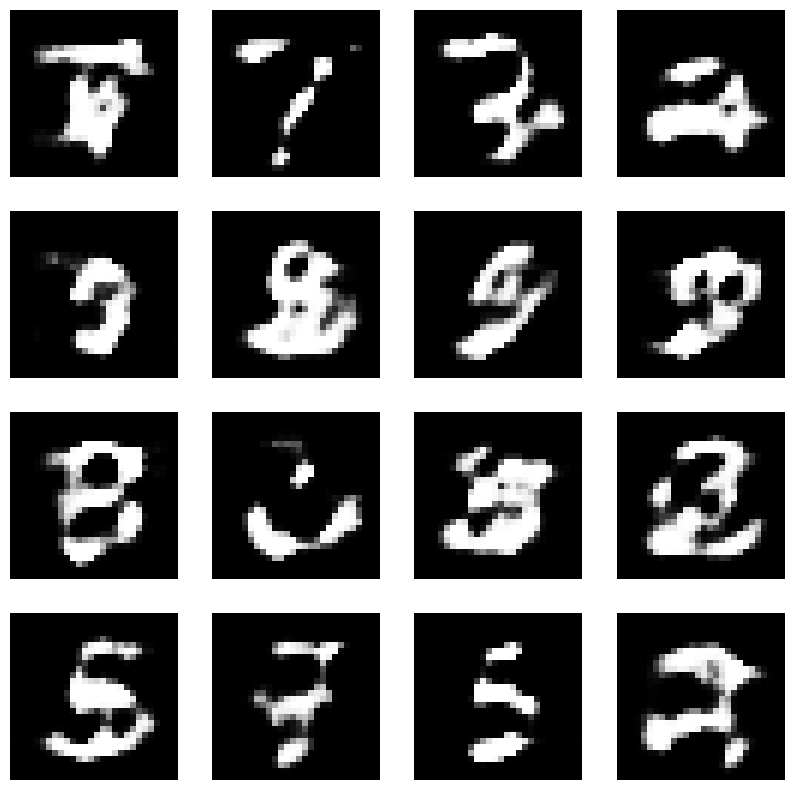

Epoch:  46


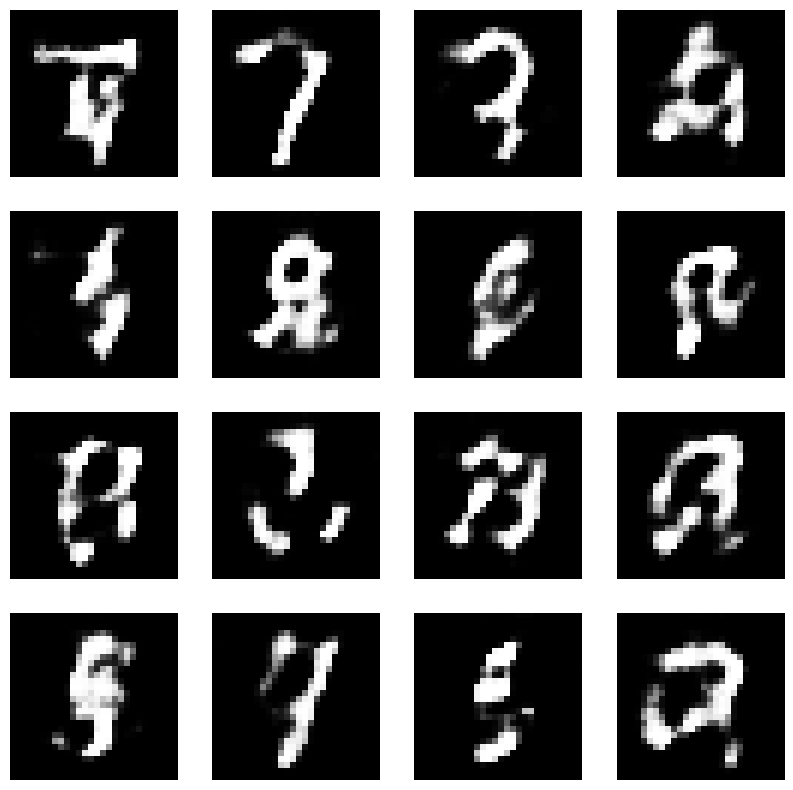

Epoch:  47


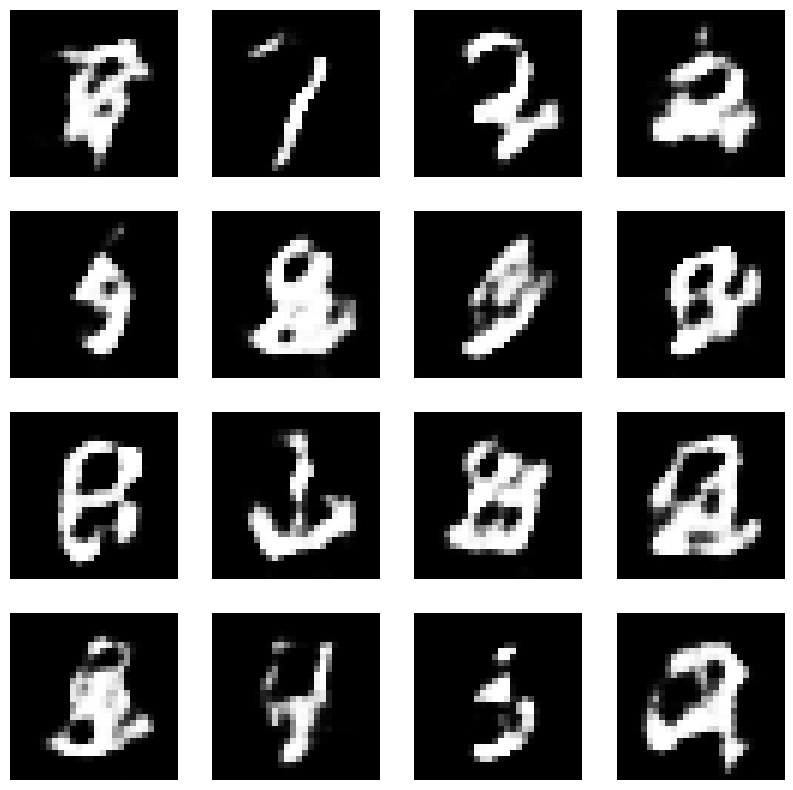

Epoch:  48


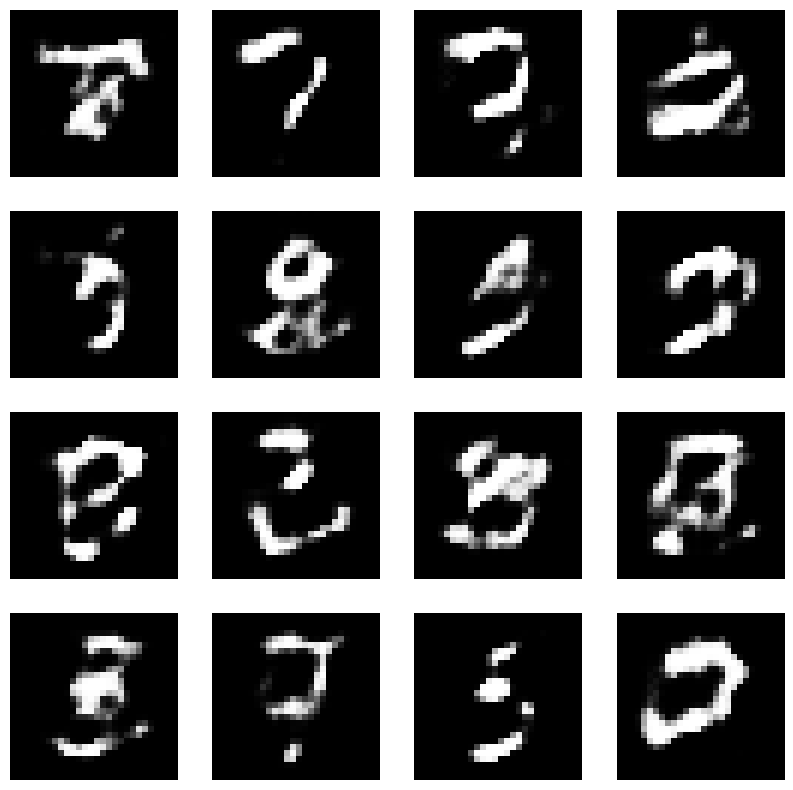

Epoch:  49


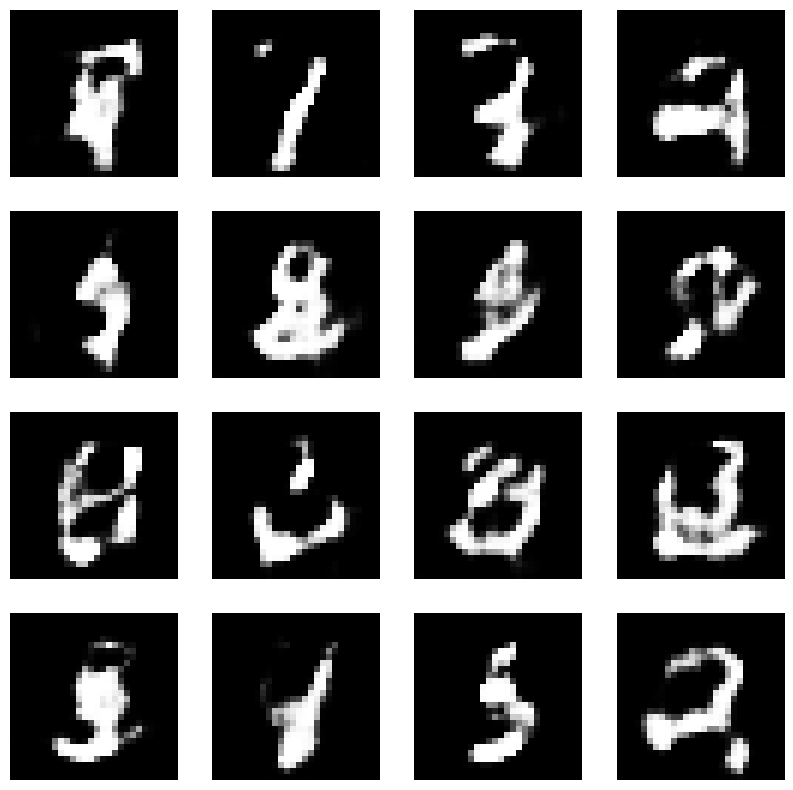

Epoch:  50


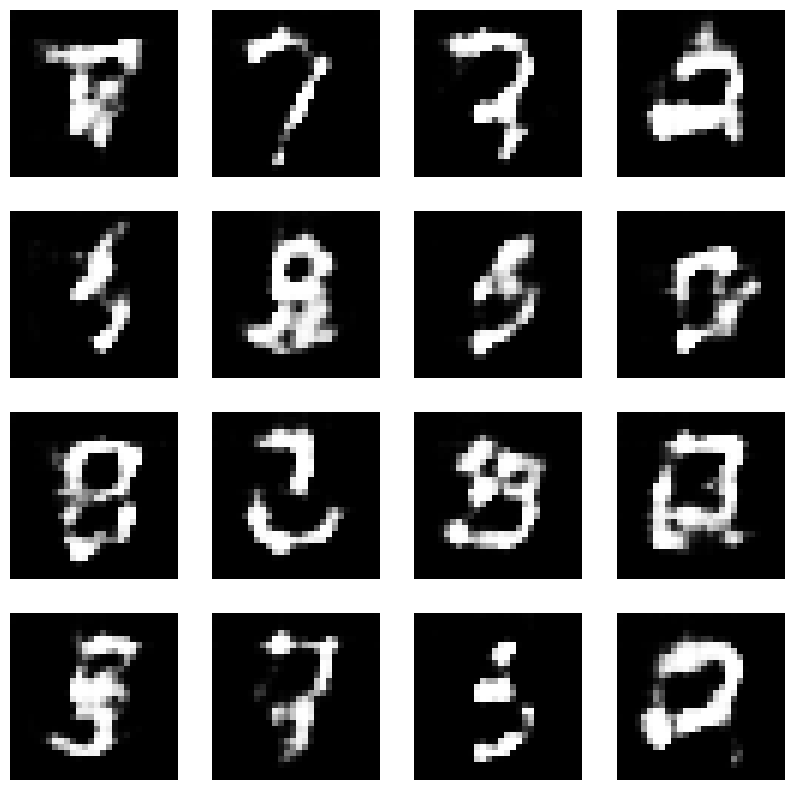

Epoch:  51


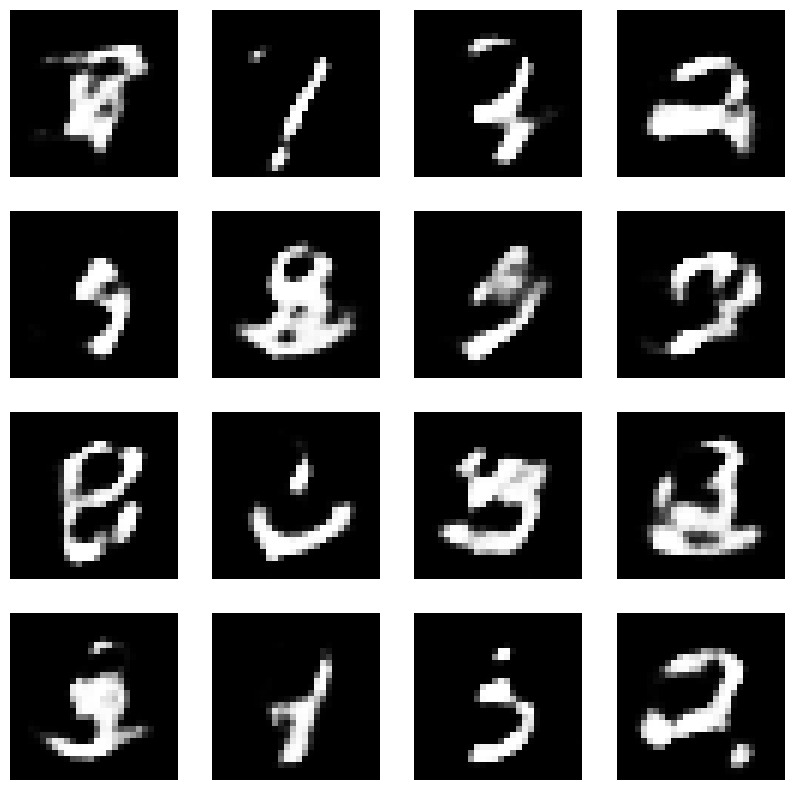

Epoch:  52


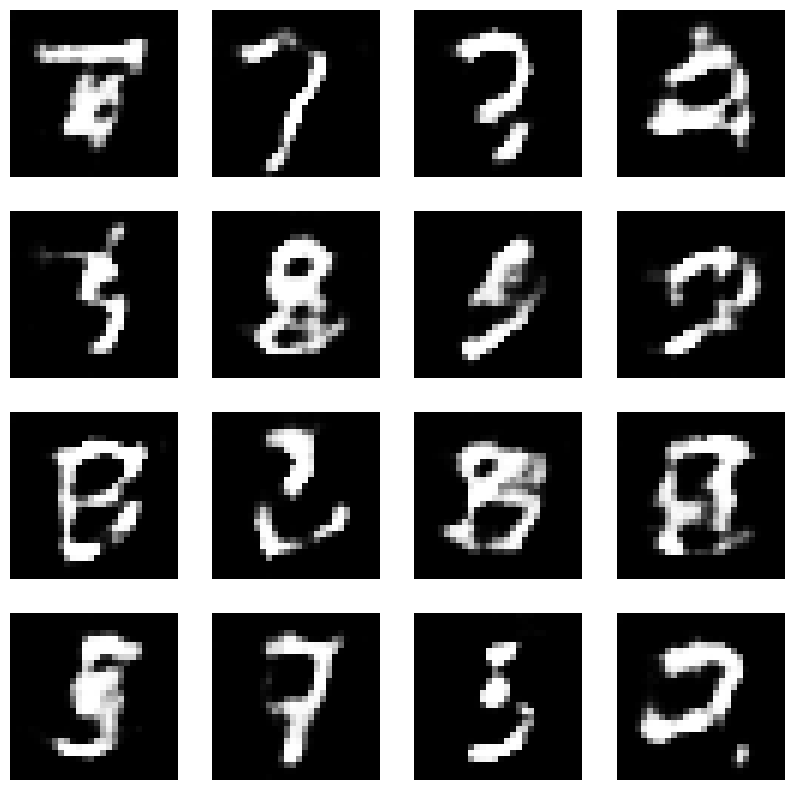

Epoch:  53


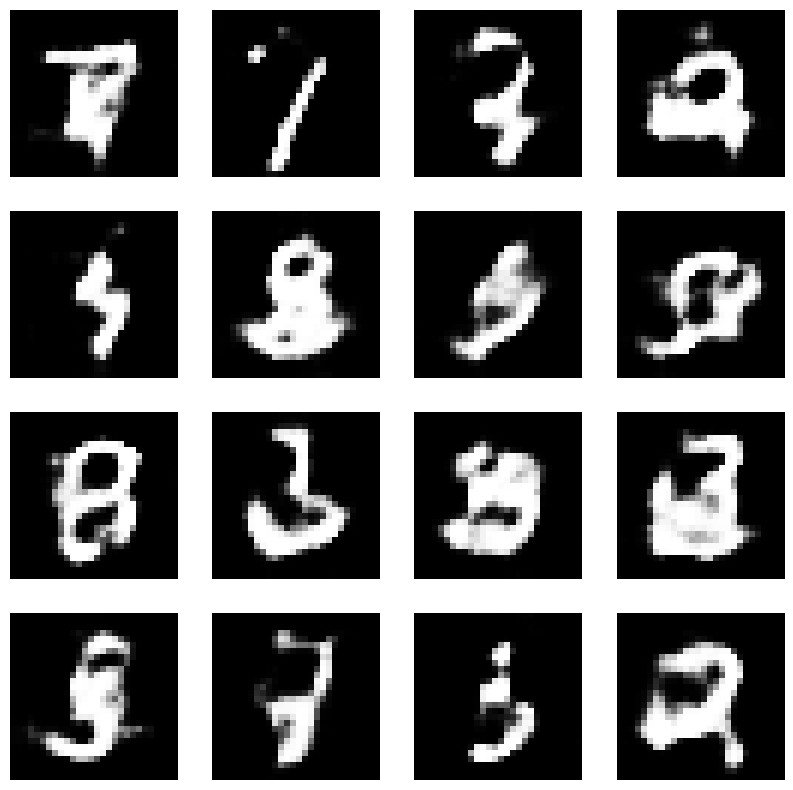

Epoch:  54


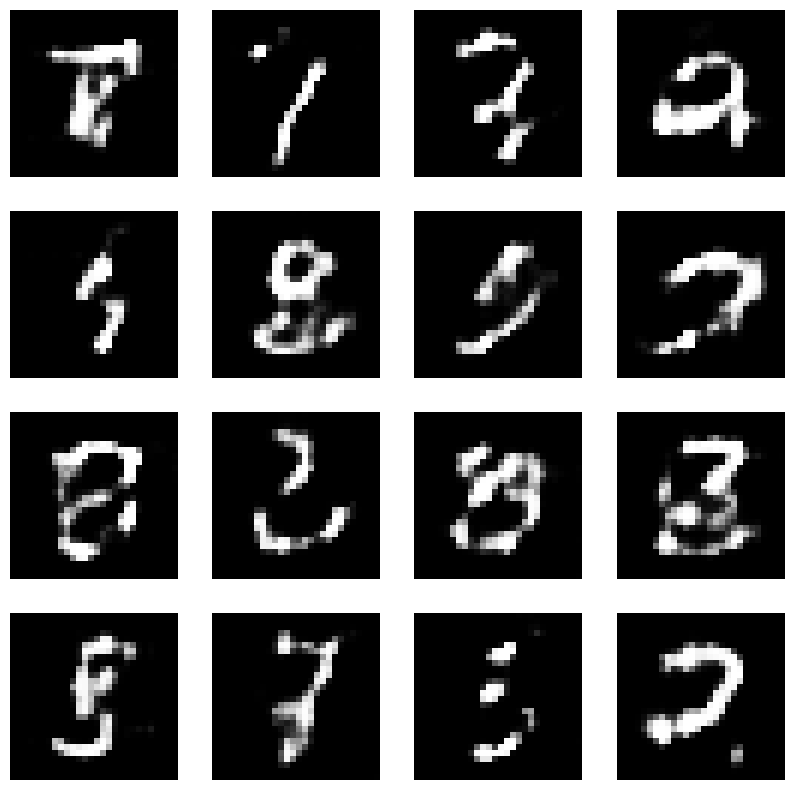

Epoch:  55


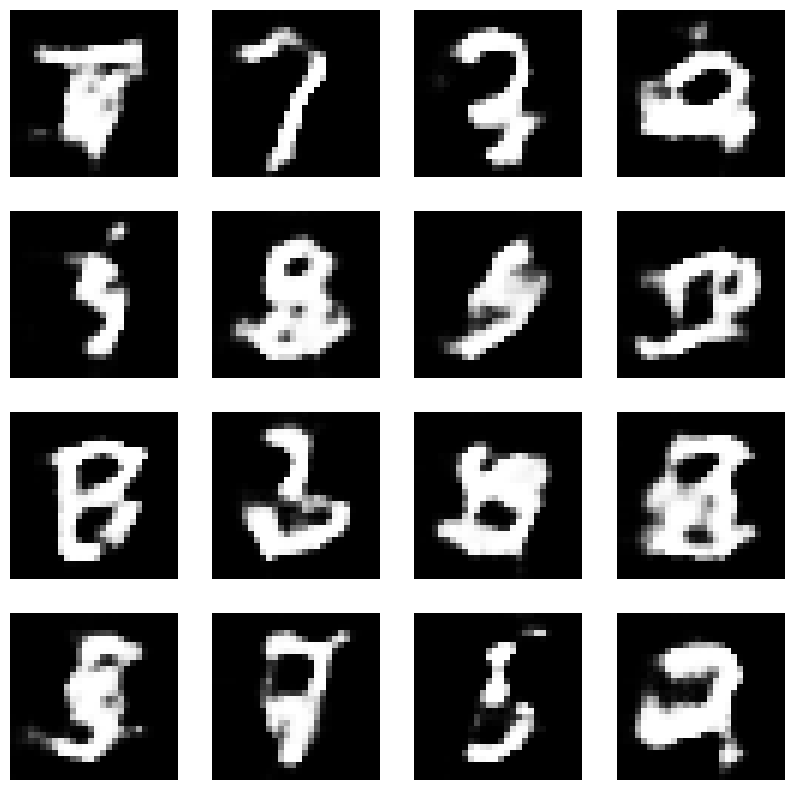

Epoch:  56


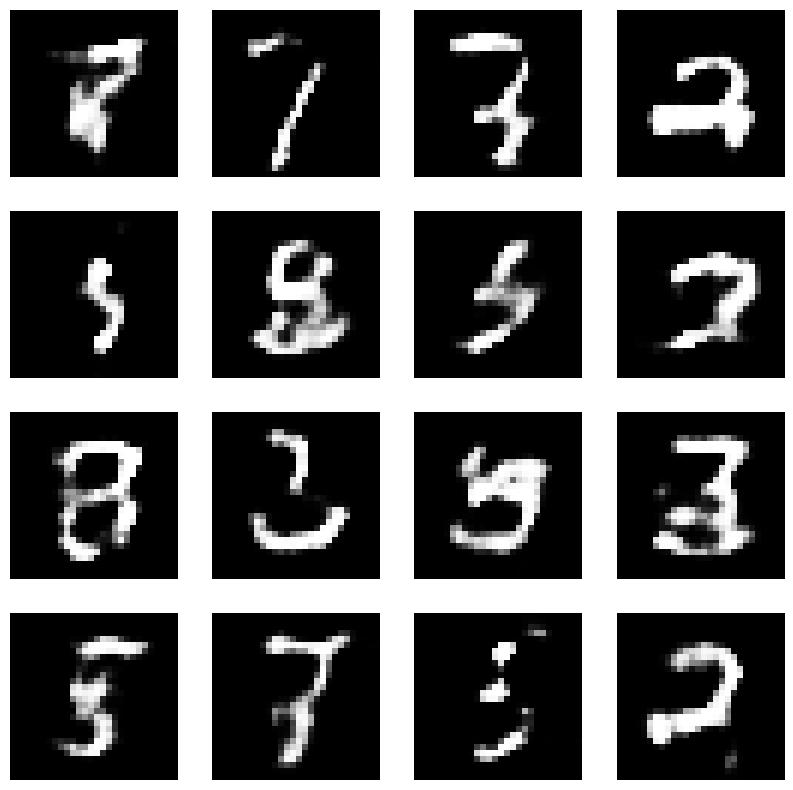

Epoch:  57


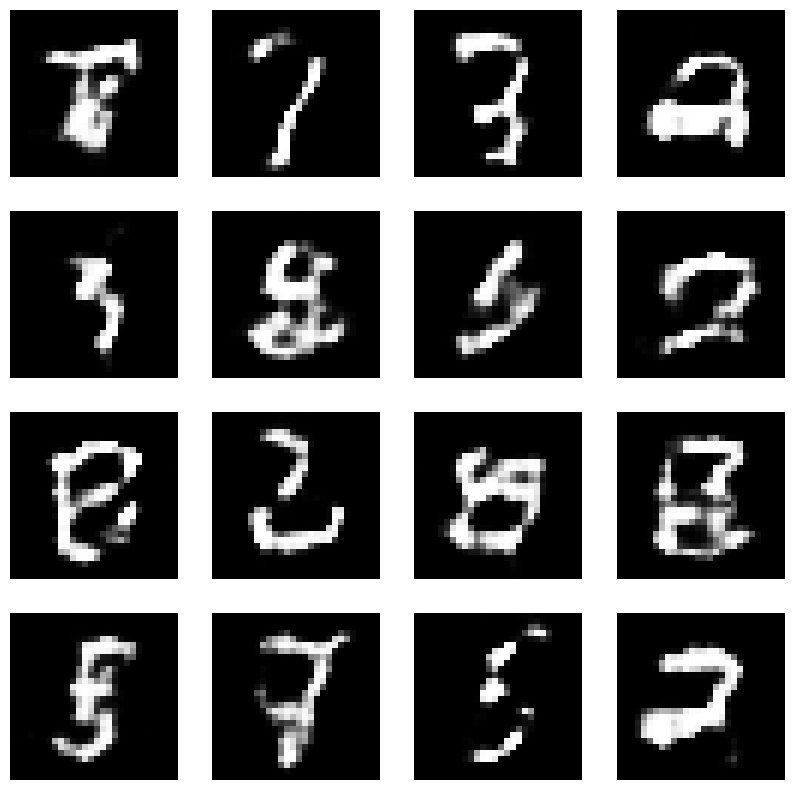

Epoch:  58


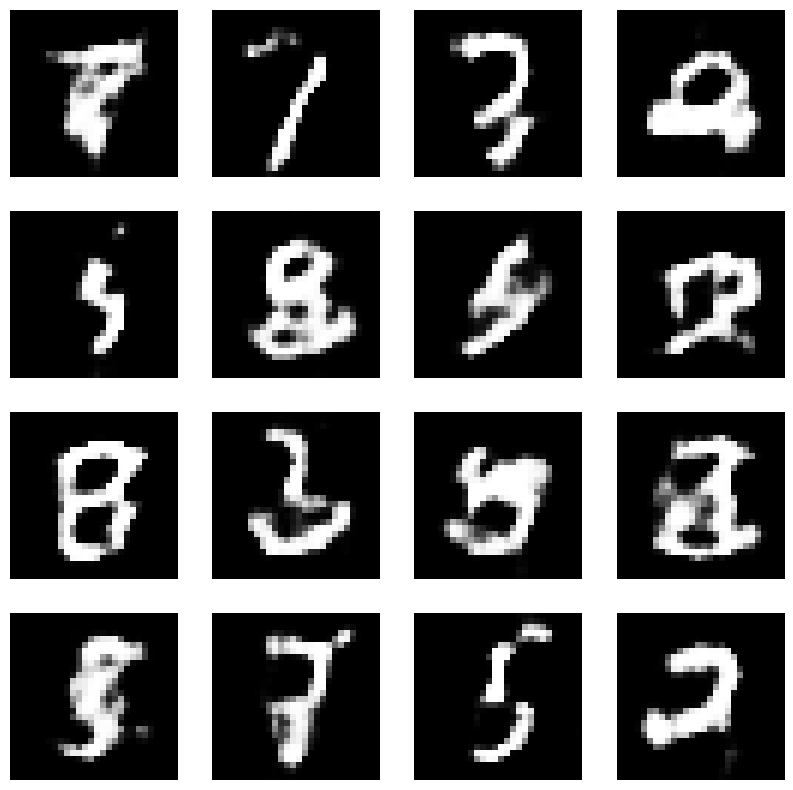

Epoch:  59


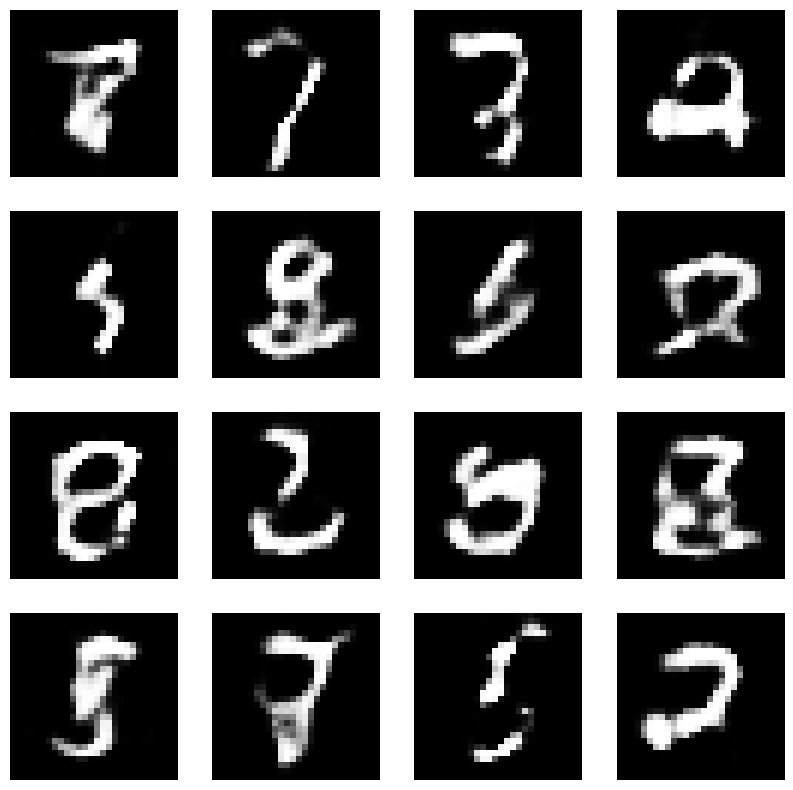

Epoch:  60


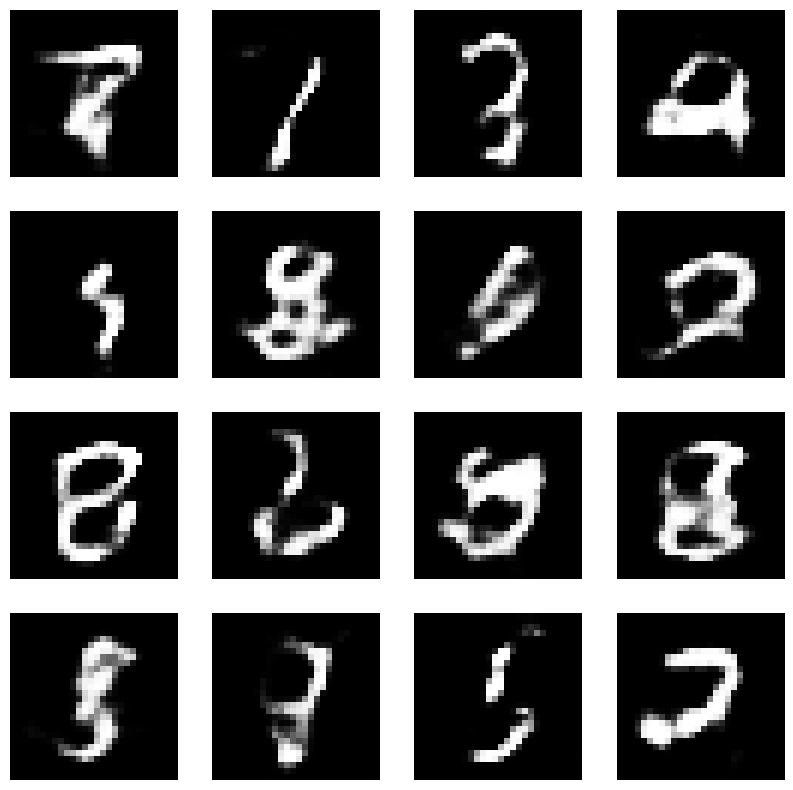

Epoch:  61


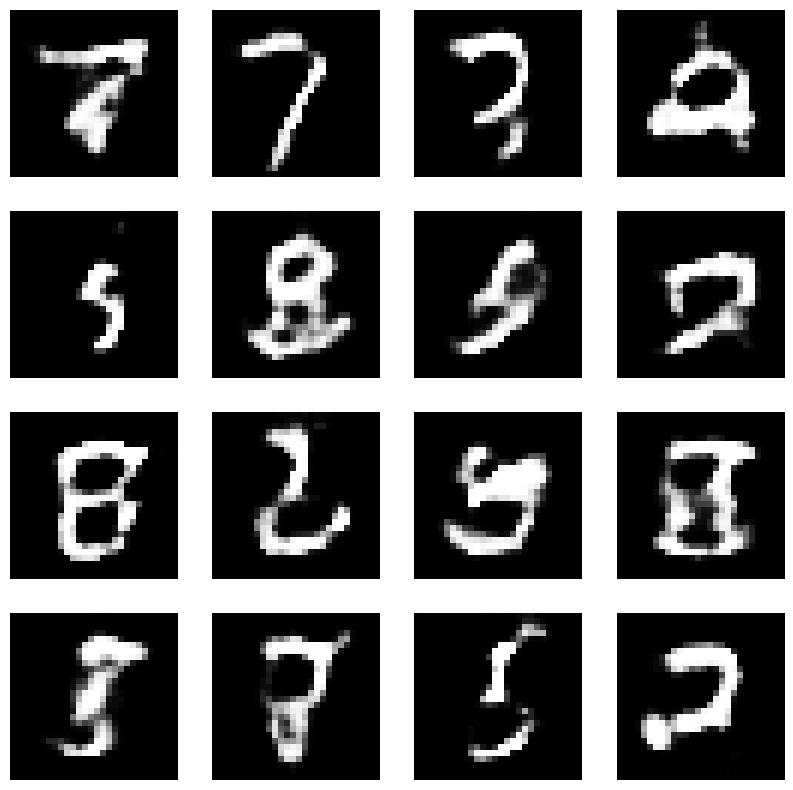

Epoch:  62


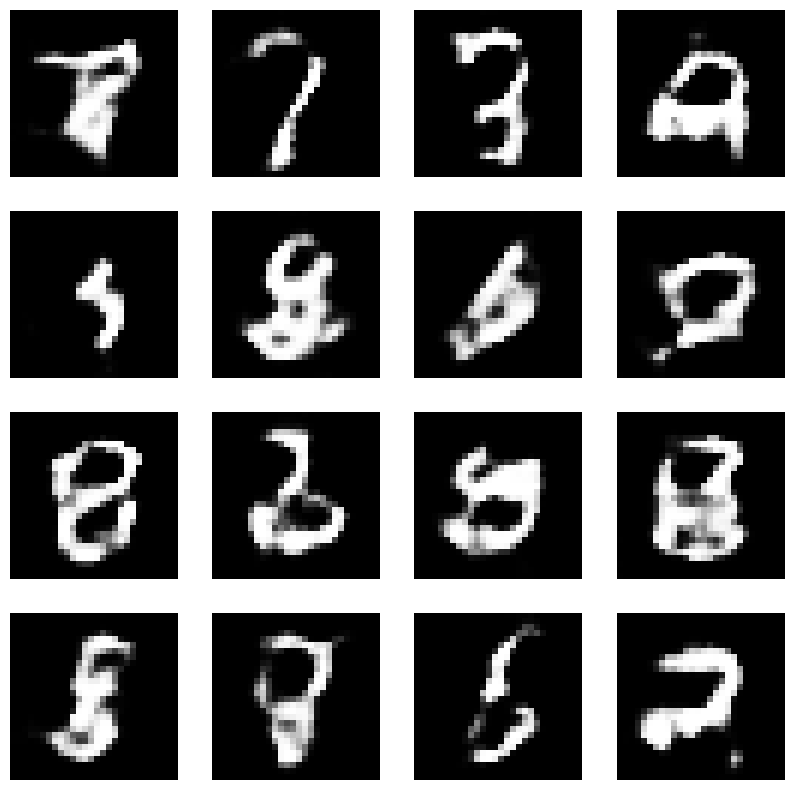

Epoch:  63


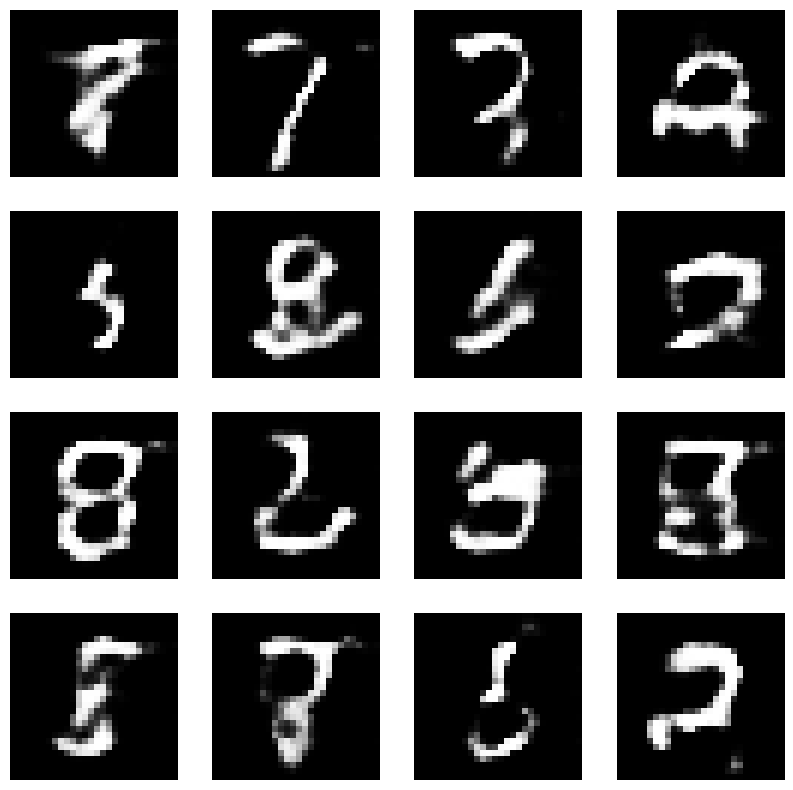

Epoch:  64


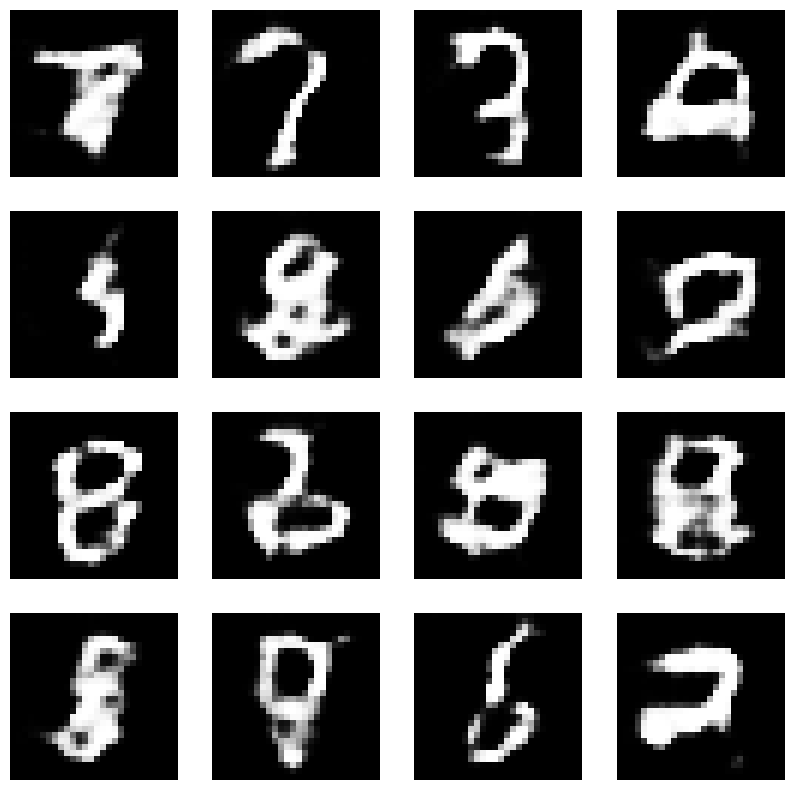

Epoch:  65


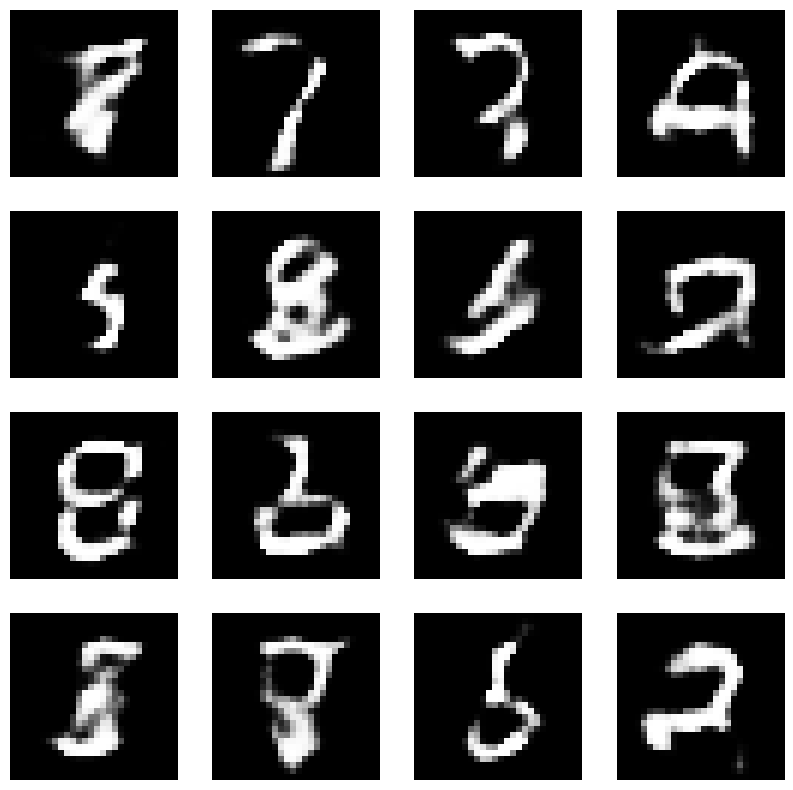

Epoch:  66


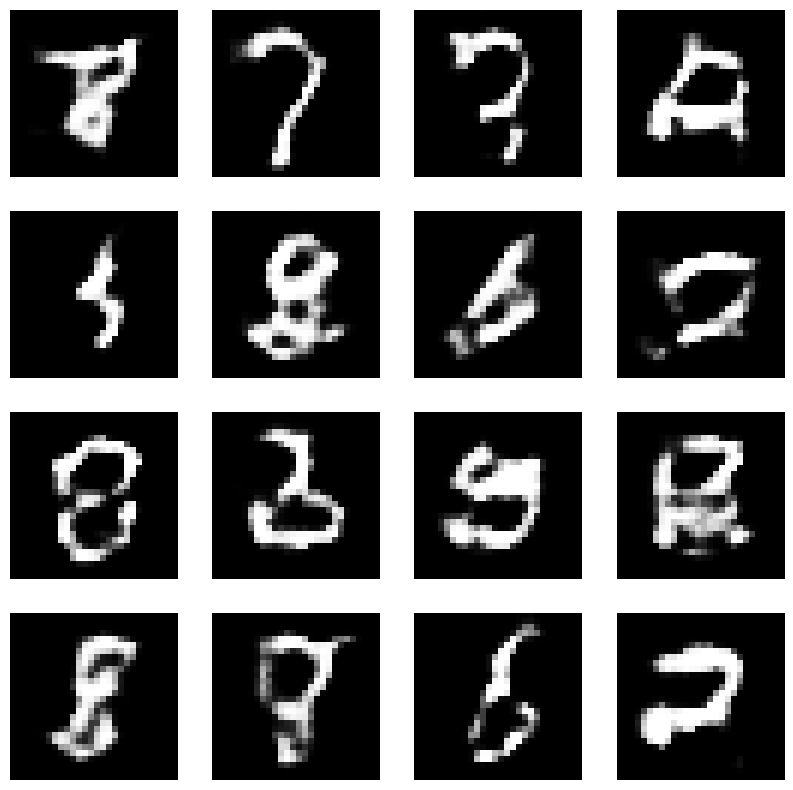

Epoch:  67


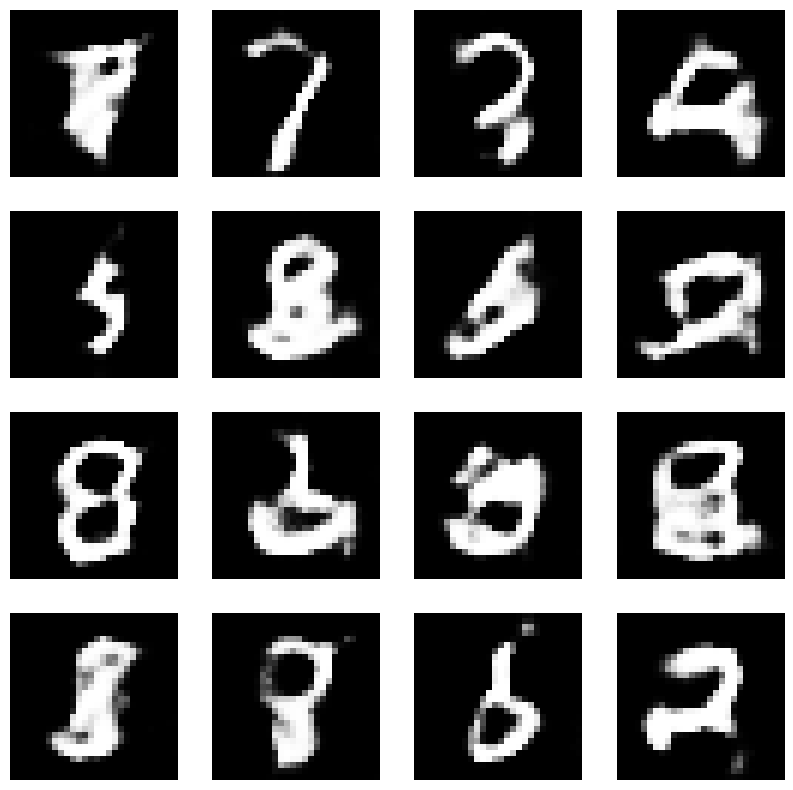

Epoch:  68


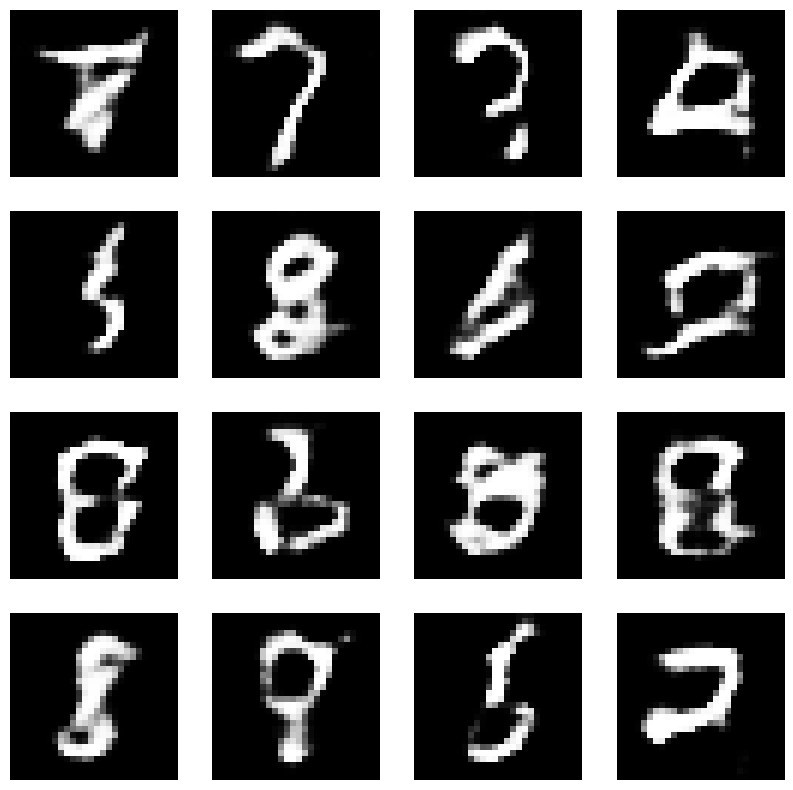

Epoch:  69


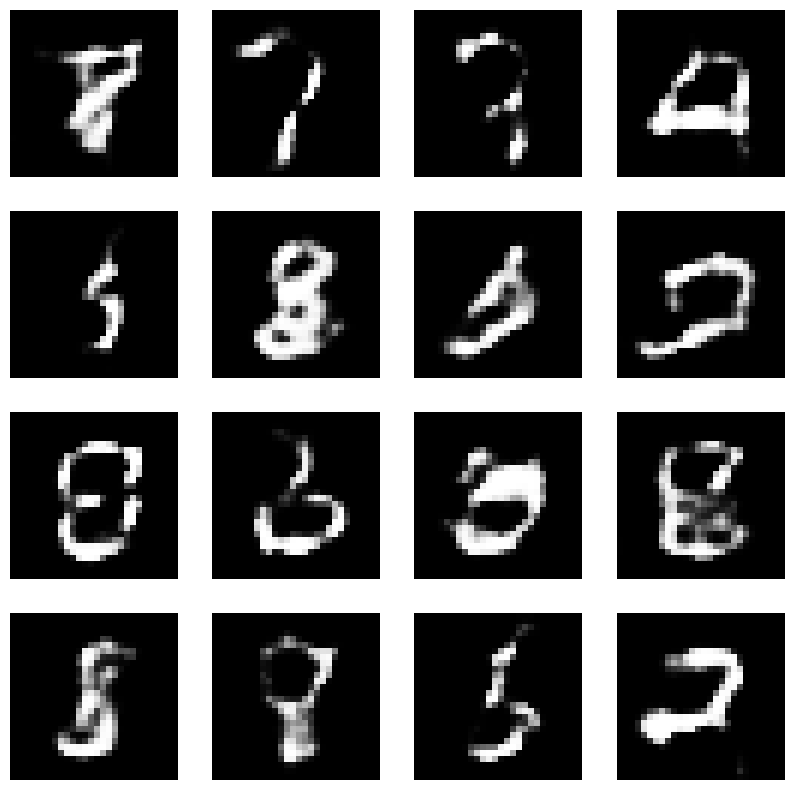

Epoch:  70


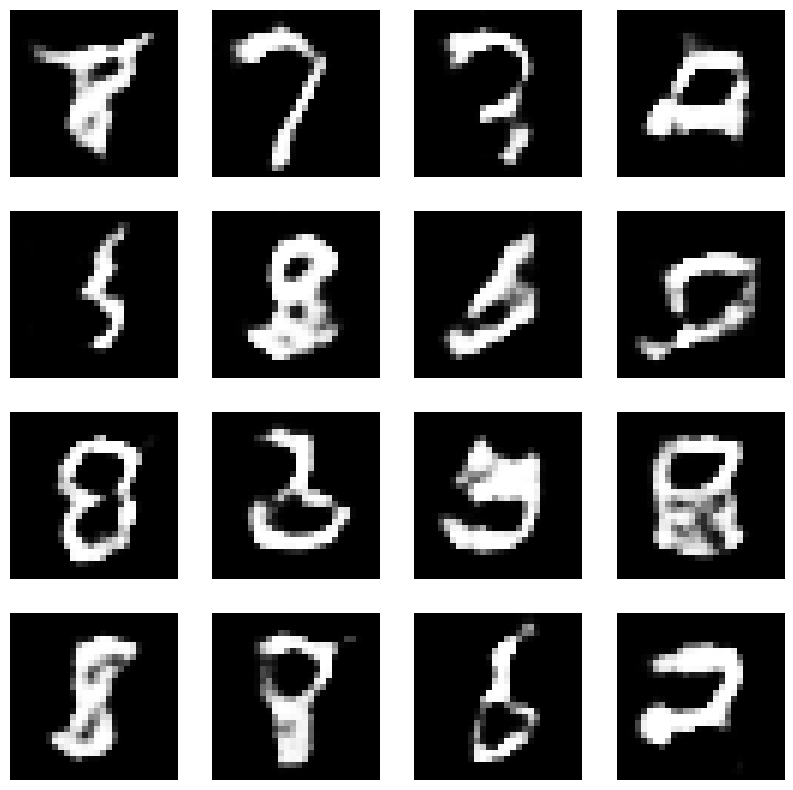

Epoch:  71


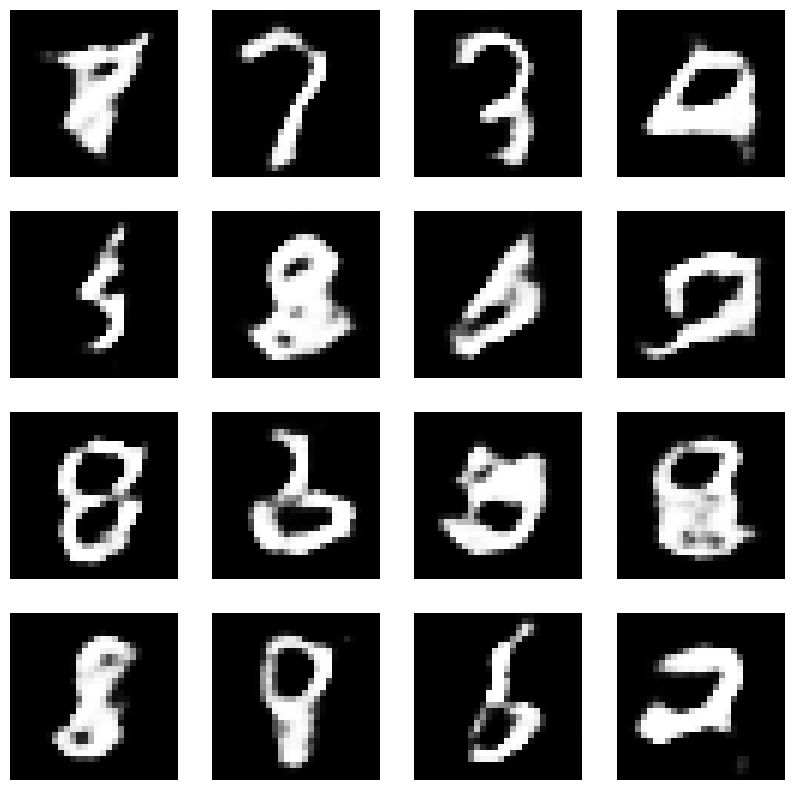

Epoch:  72


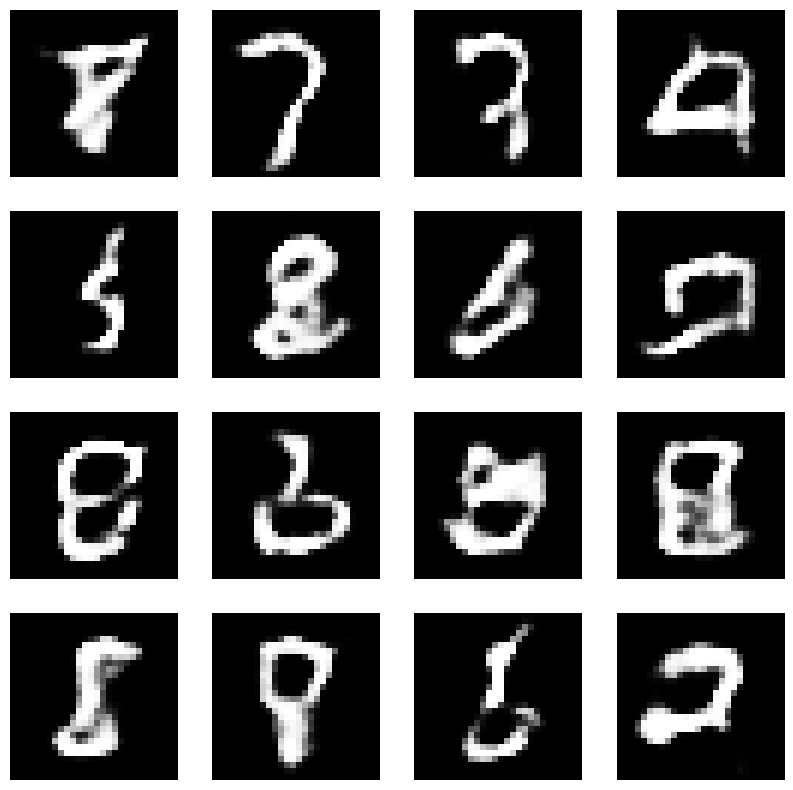

Epoch:  73


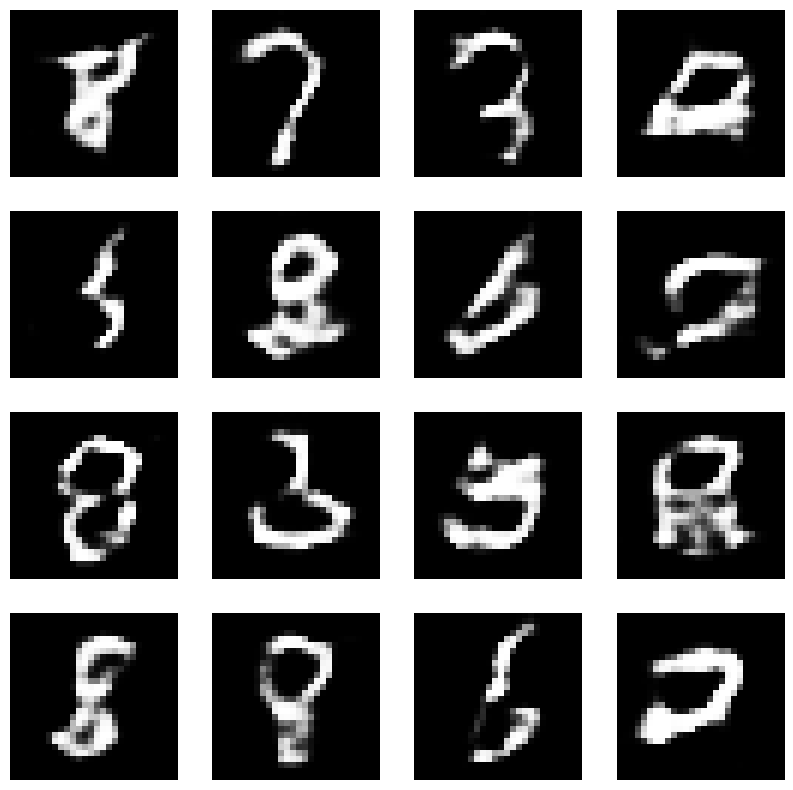

Epoch:  74


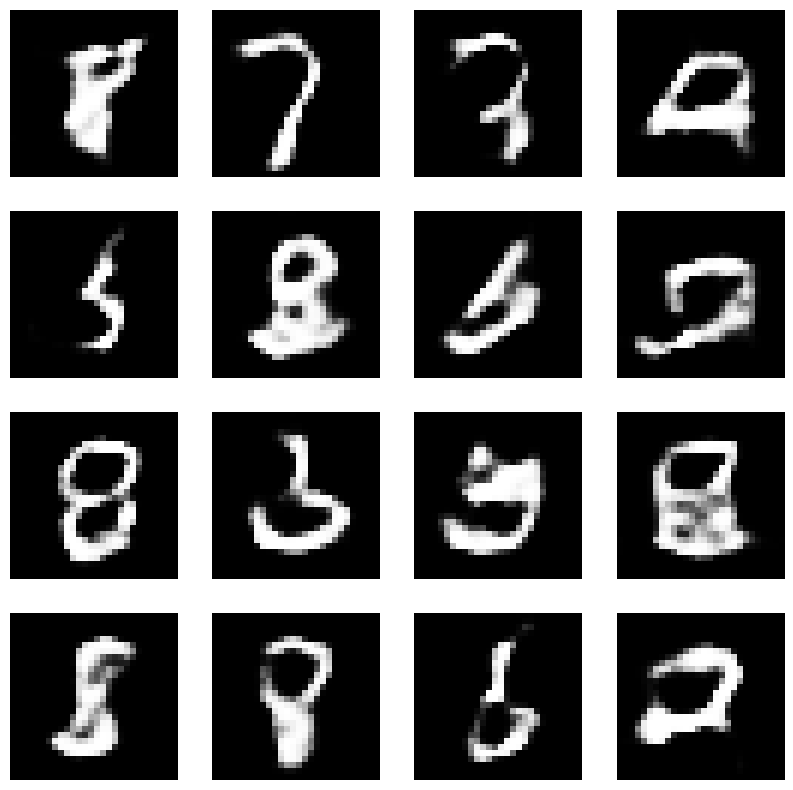

Epoch:  75


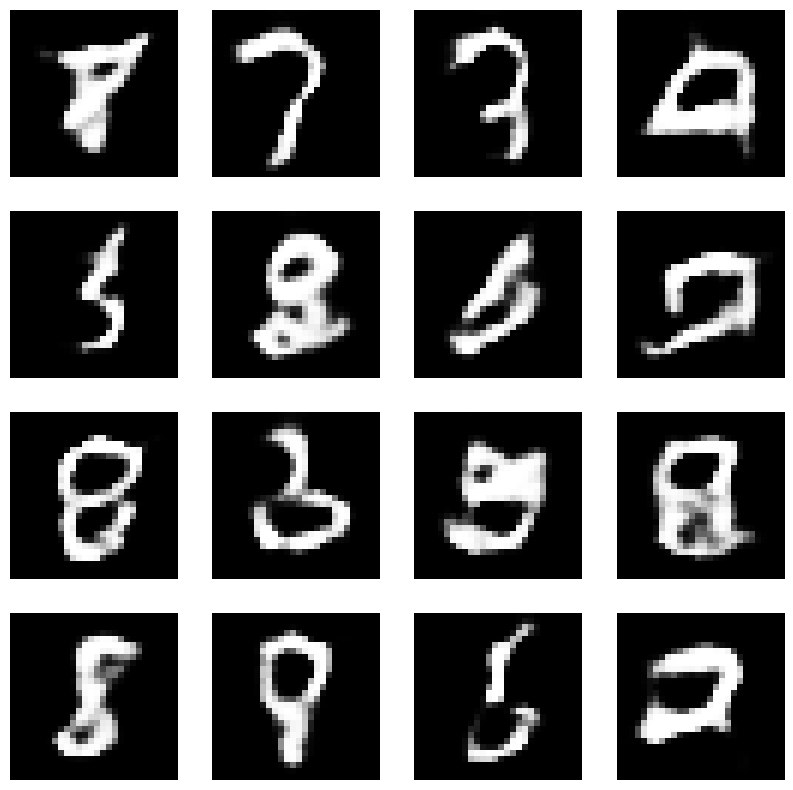

Epoch:  76


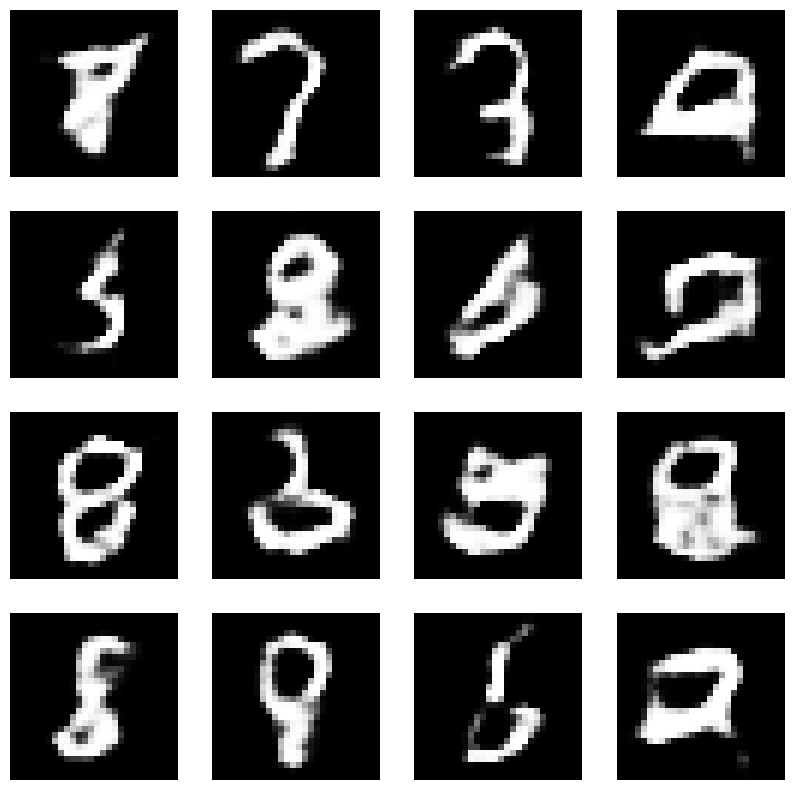

Epoch:  77


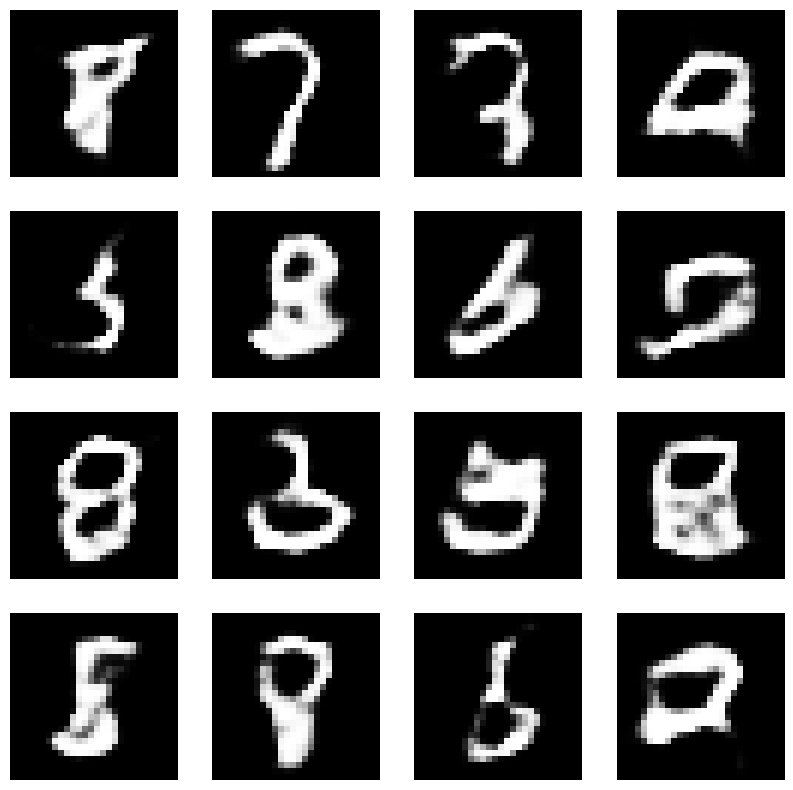

Epoch:  78


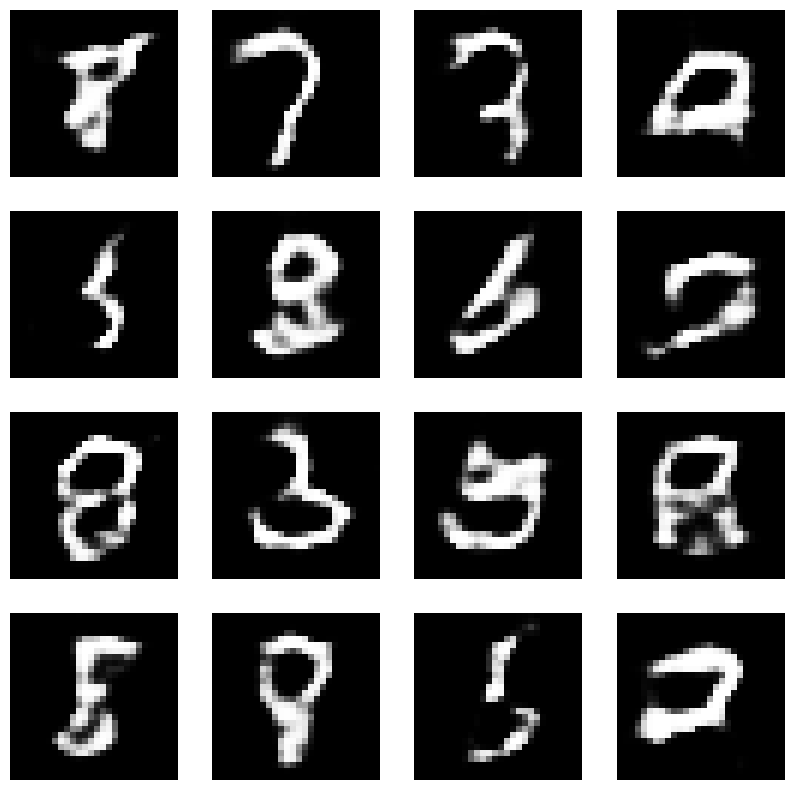

Epoch:  79


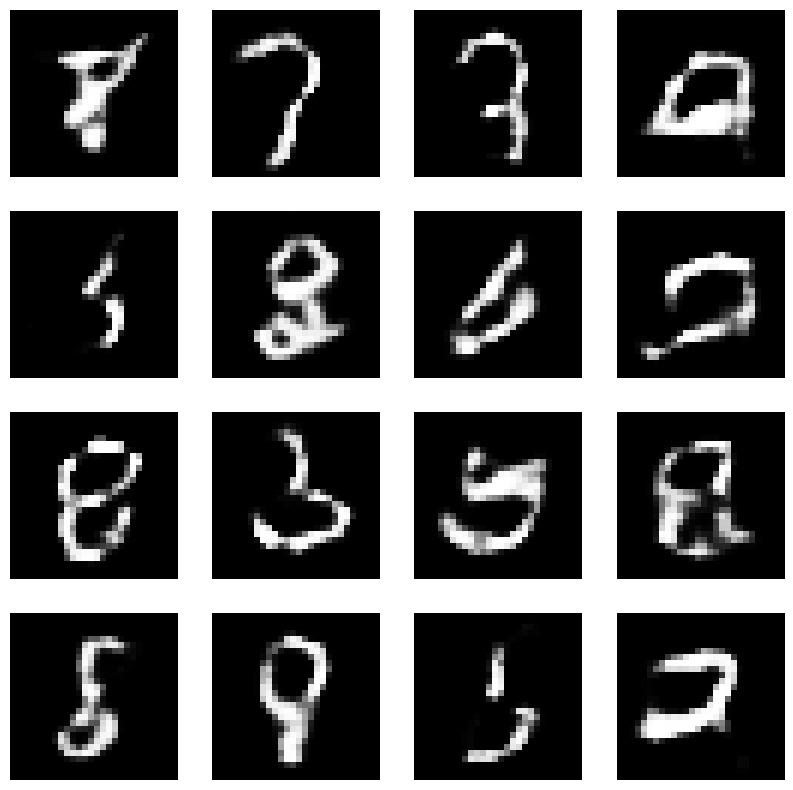

Epoch:  80


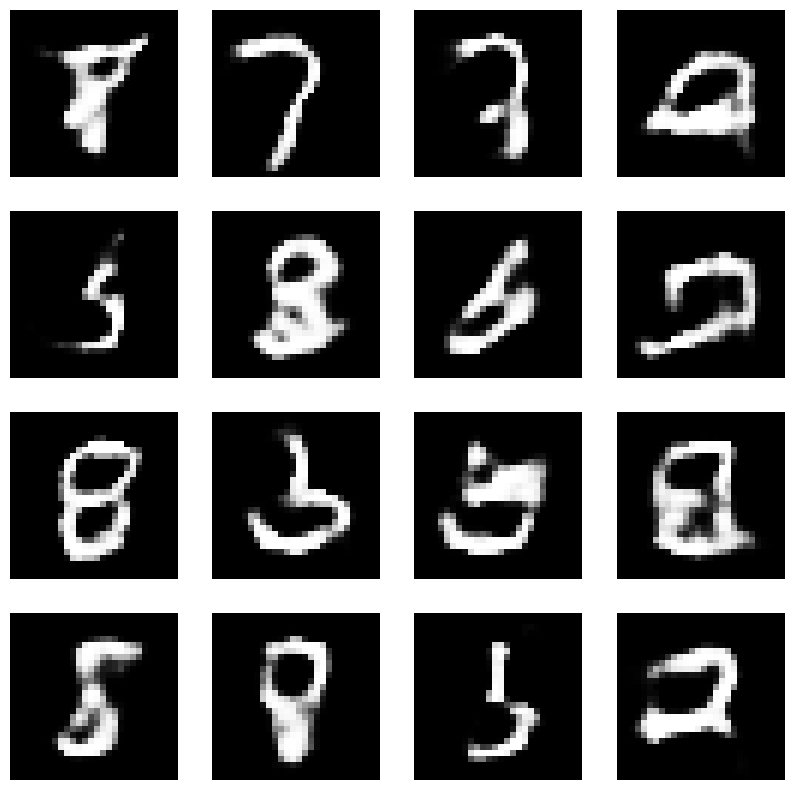

Epoch:  81


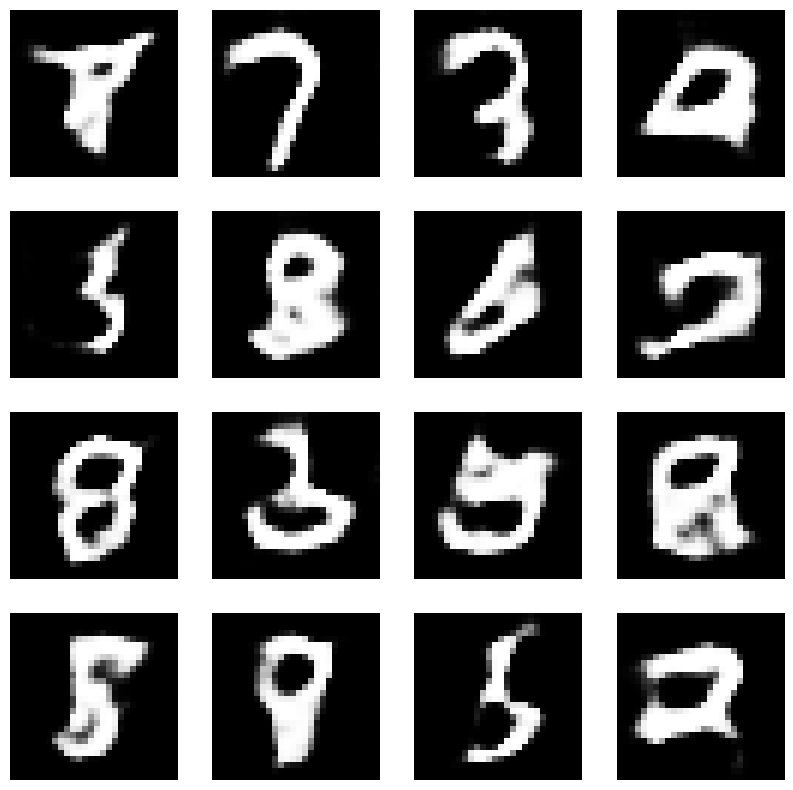

Epoch:  82


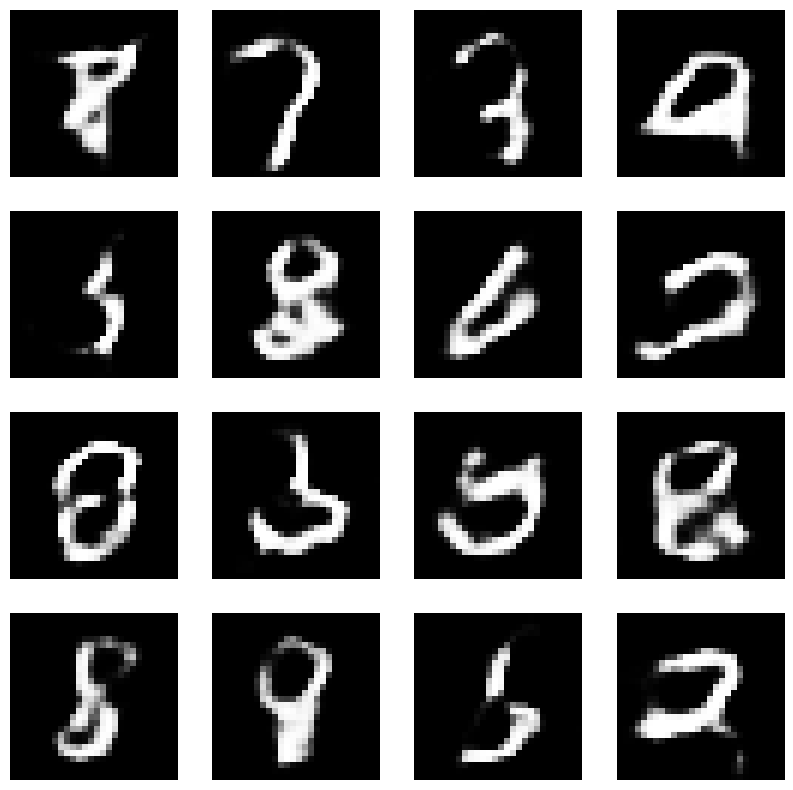

Epoch:  83


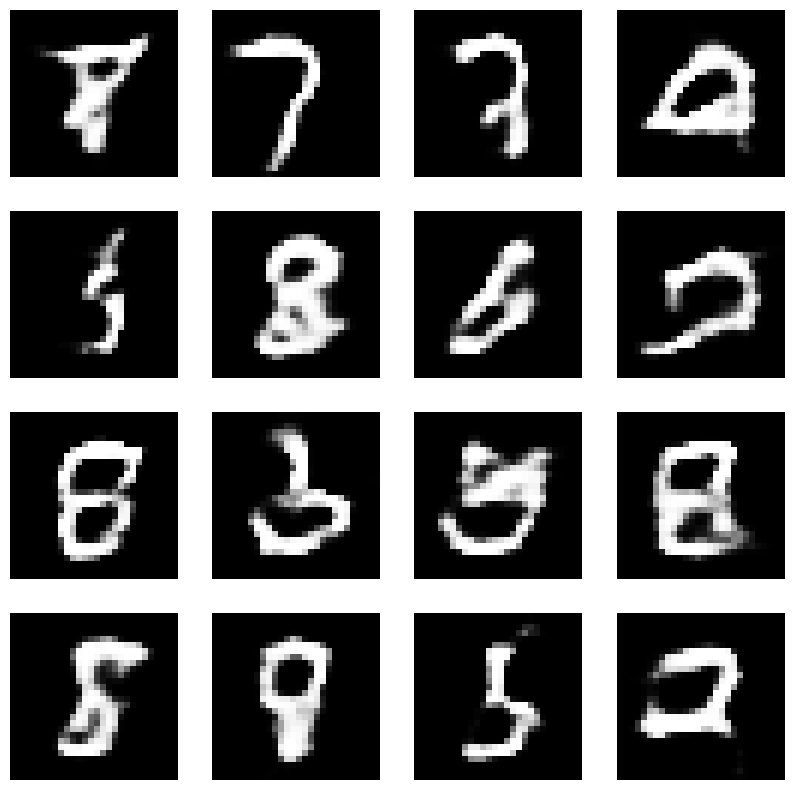

Epoch:  84


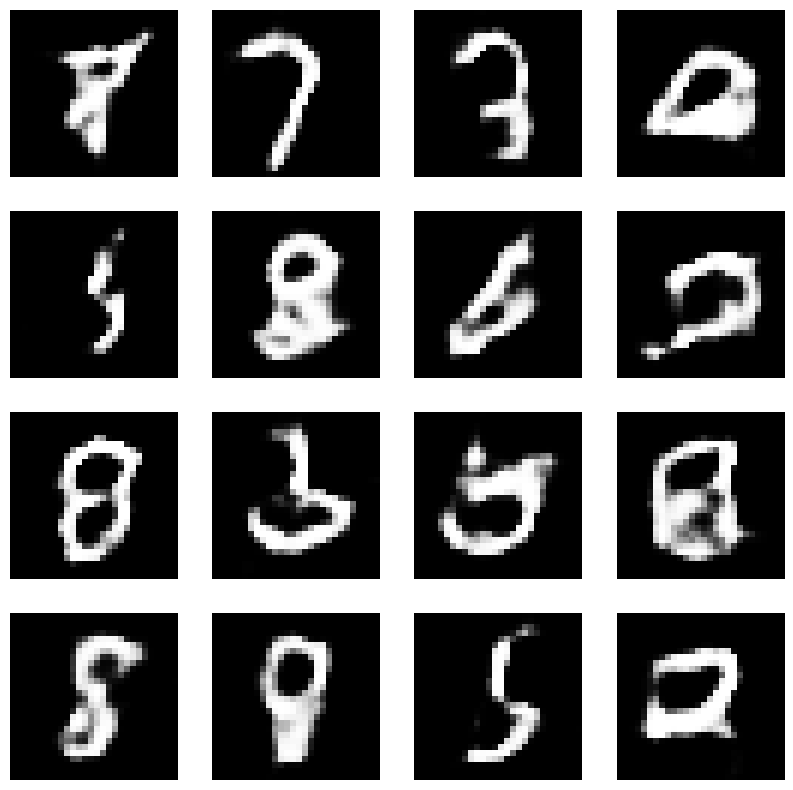

Epoch:  85


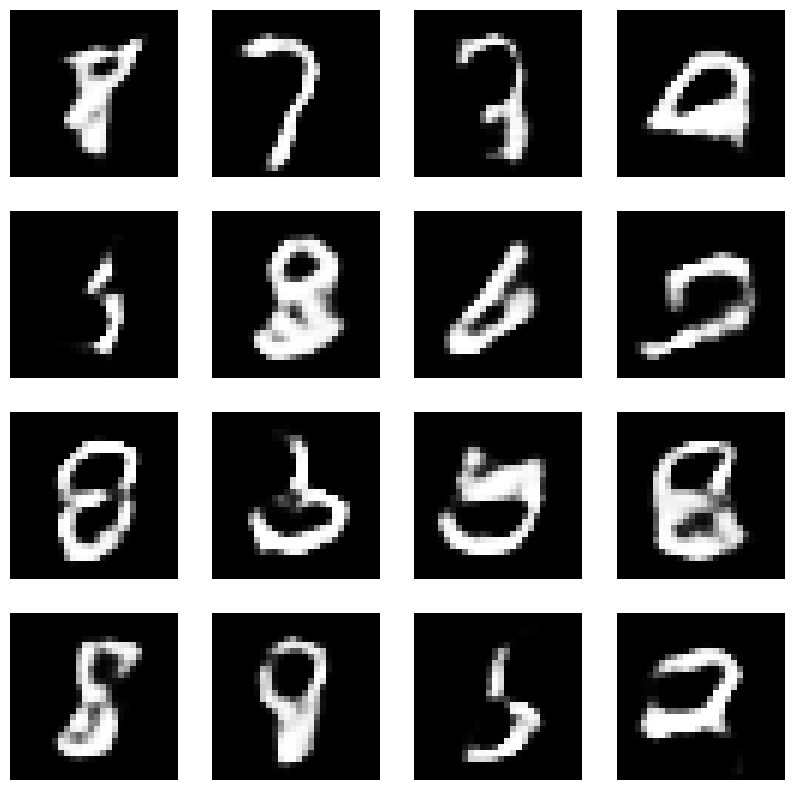

Epoch:  86


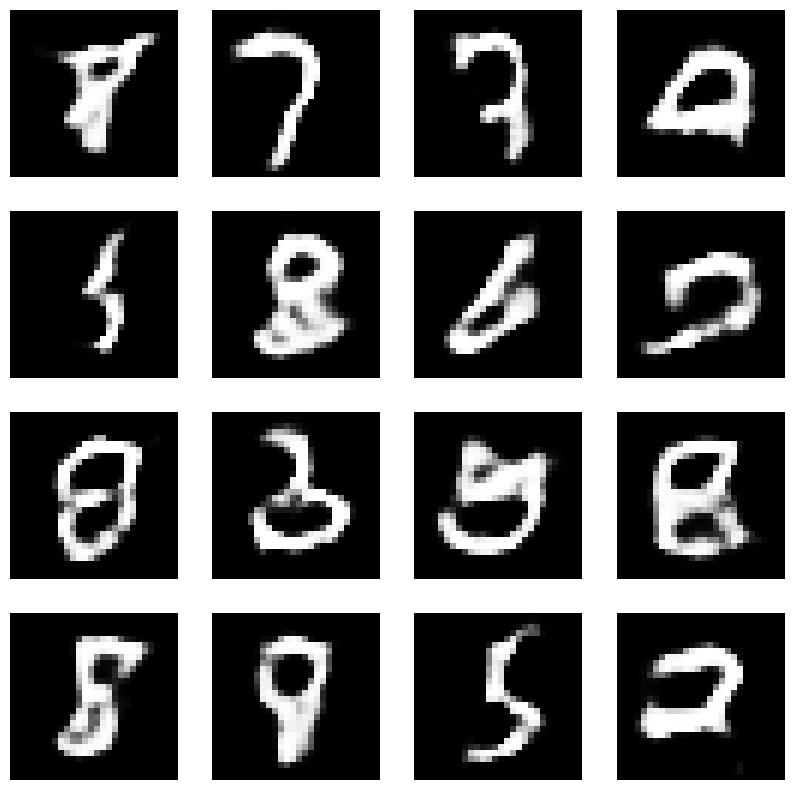

Epoch:  87


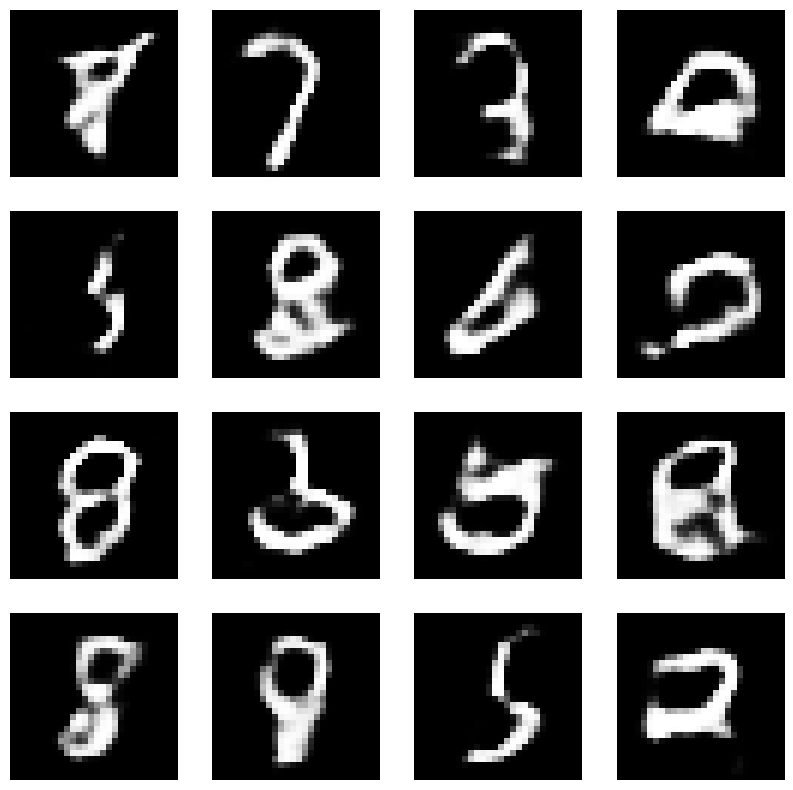

Epoch:  88


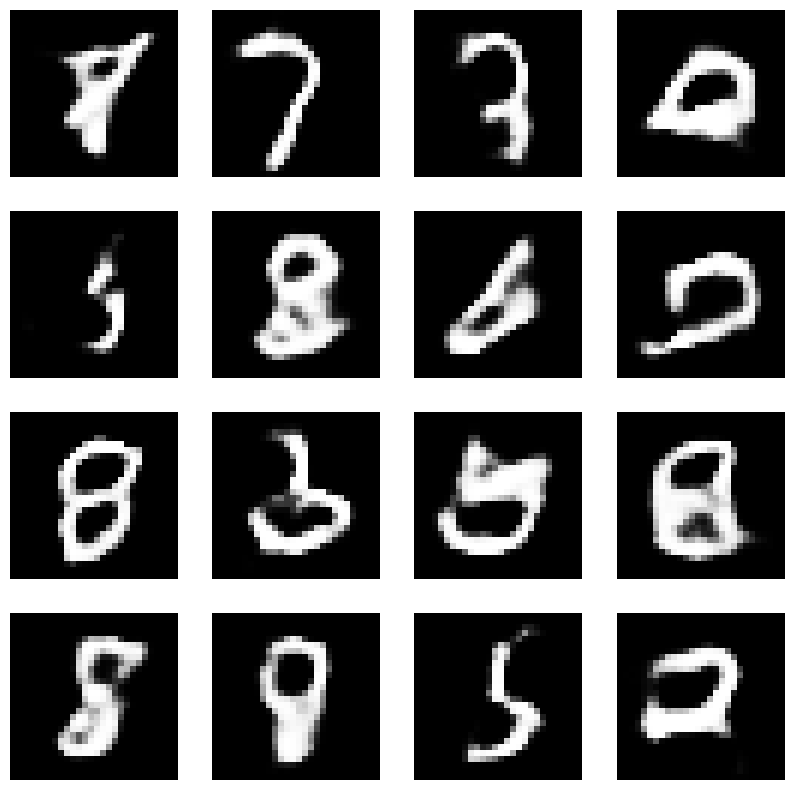

Epoch:  89


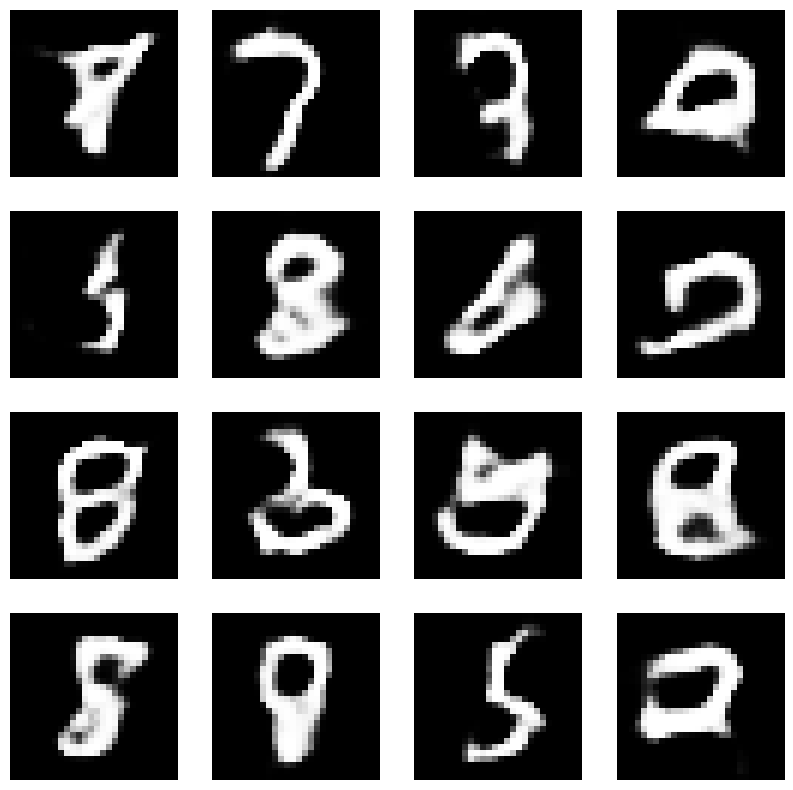

Epoch:  90


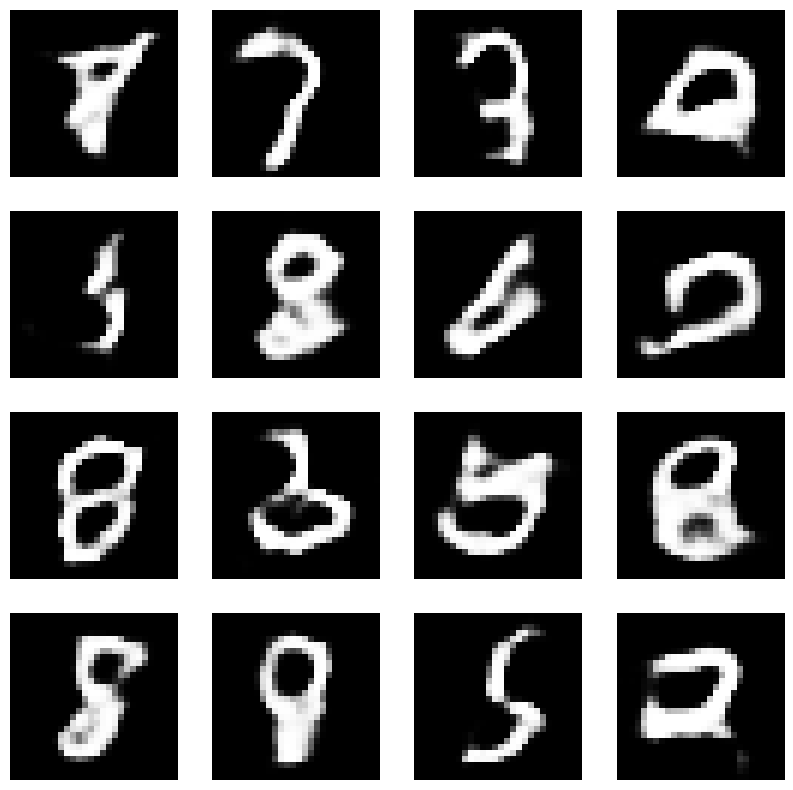

Epoch:  91


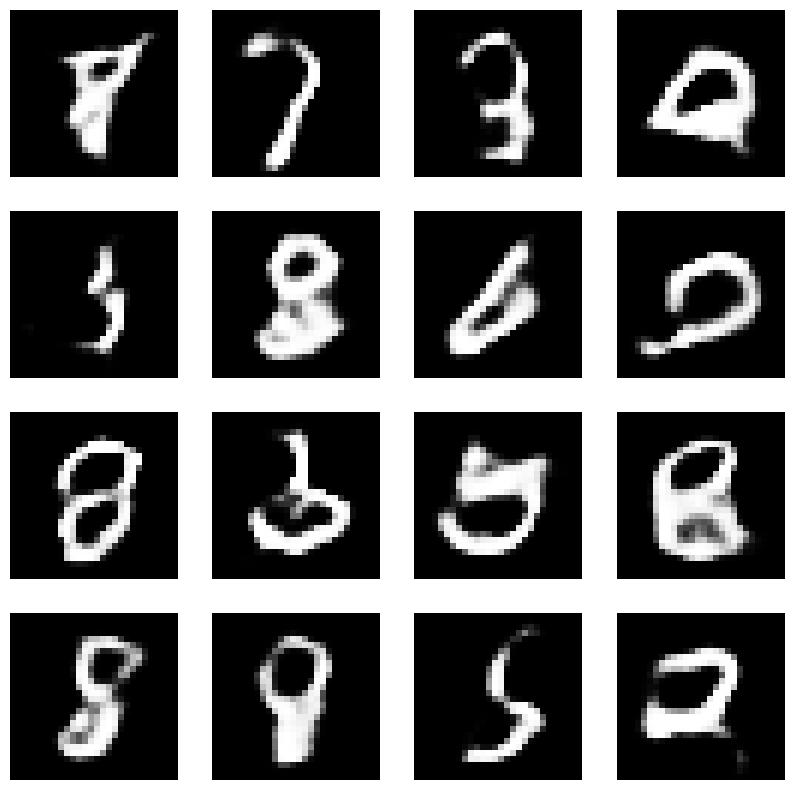

Epoch:  92


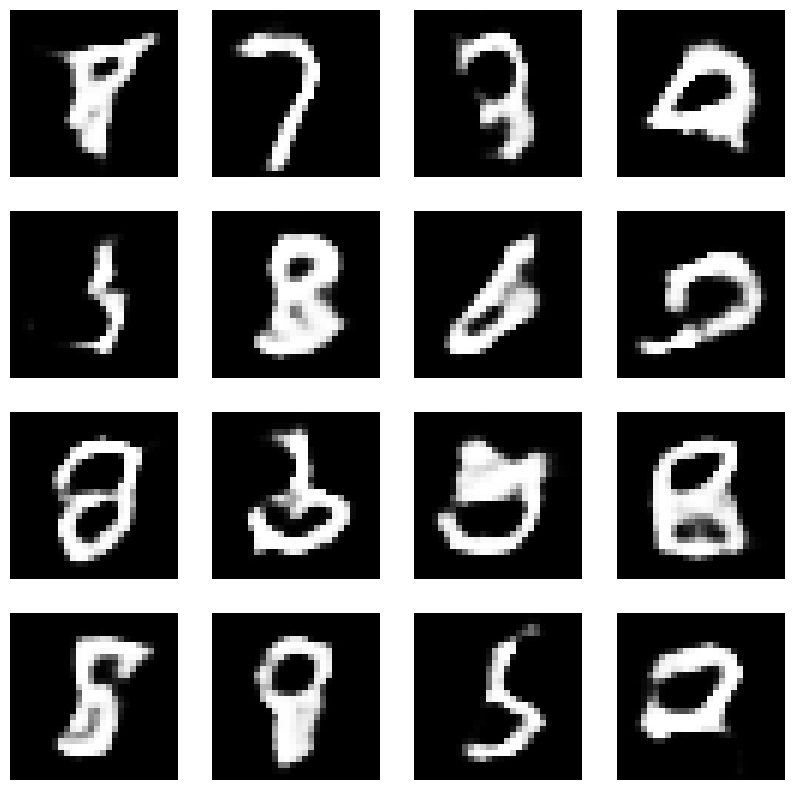

Epoch:  93


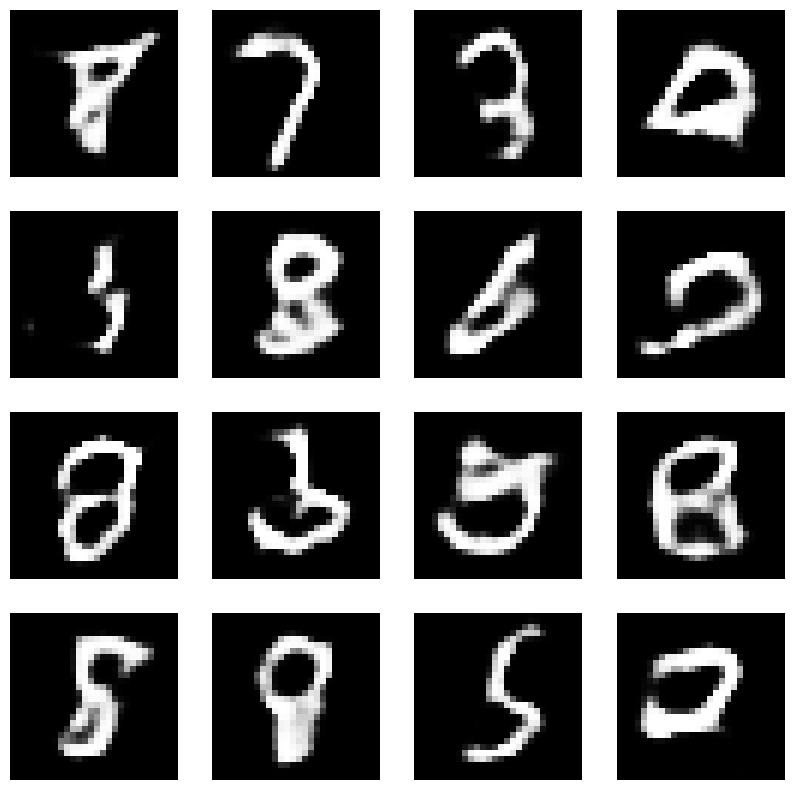

Epoch:  94


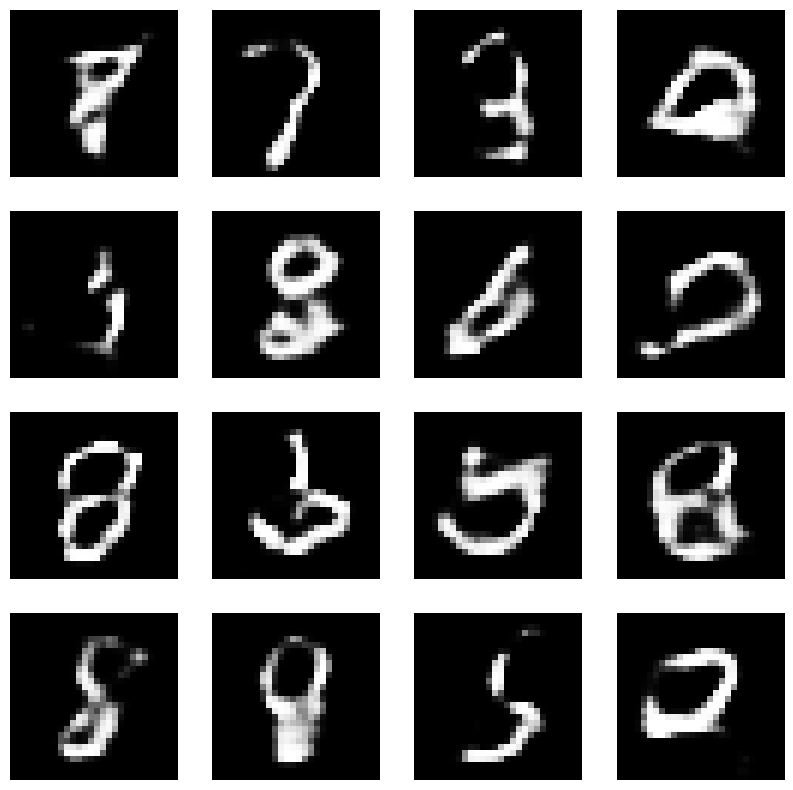

Epoch:  95


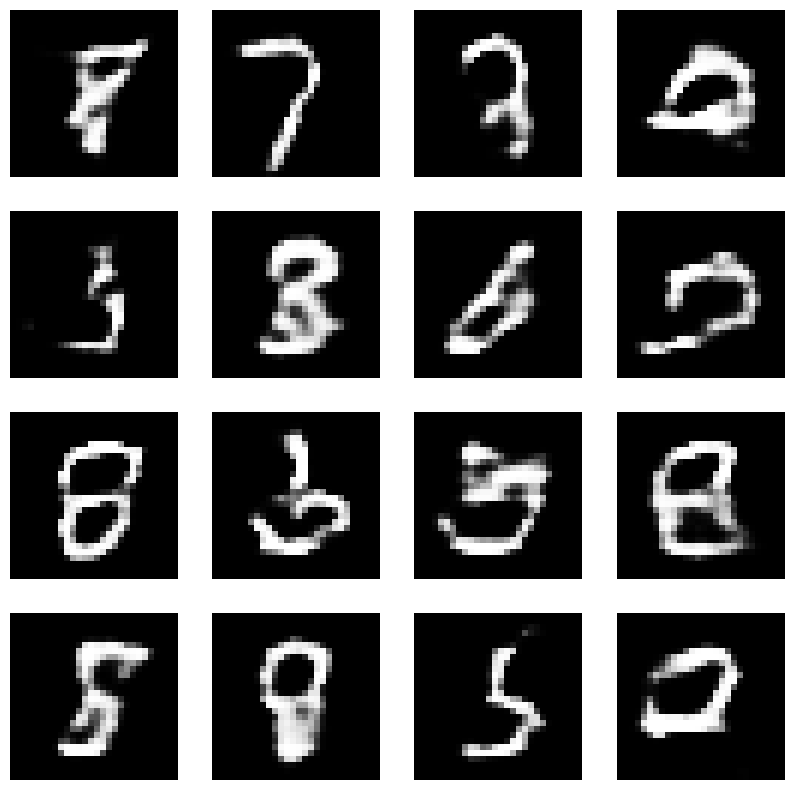

Epoch:  96


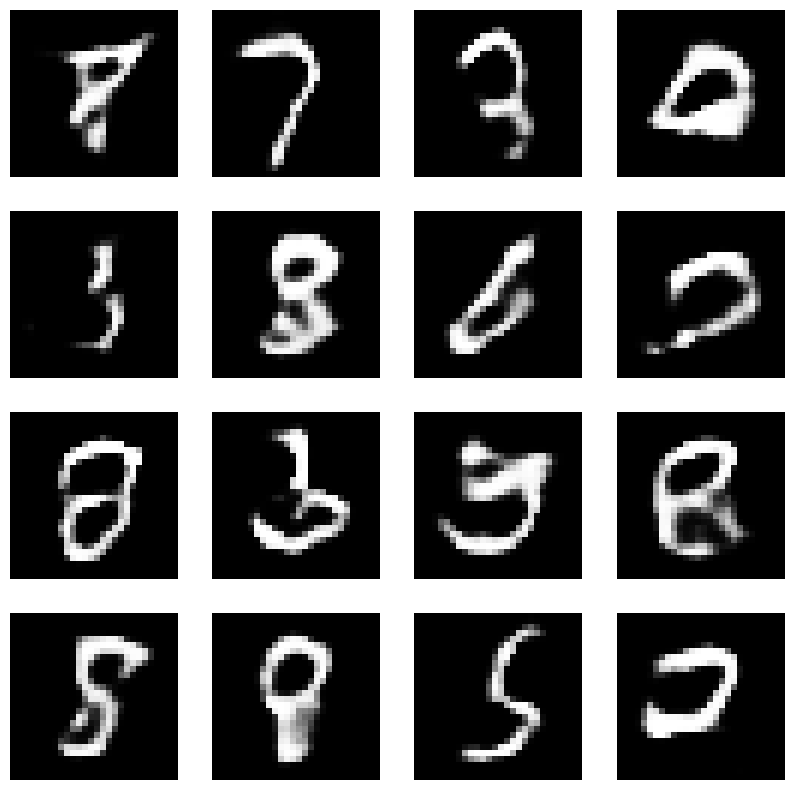

Epoch:  97


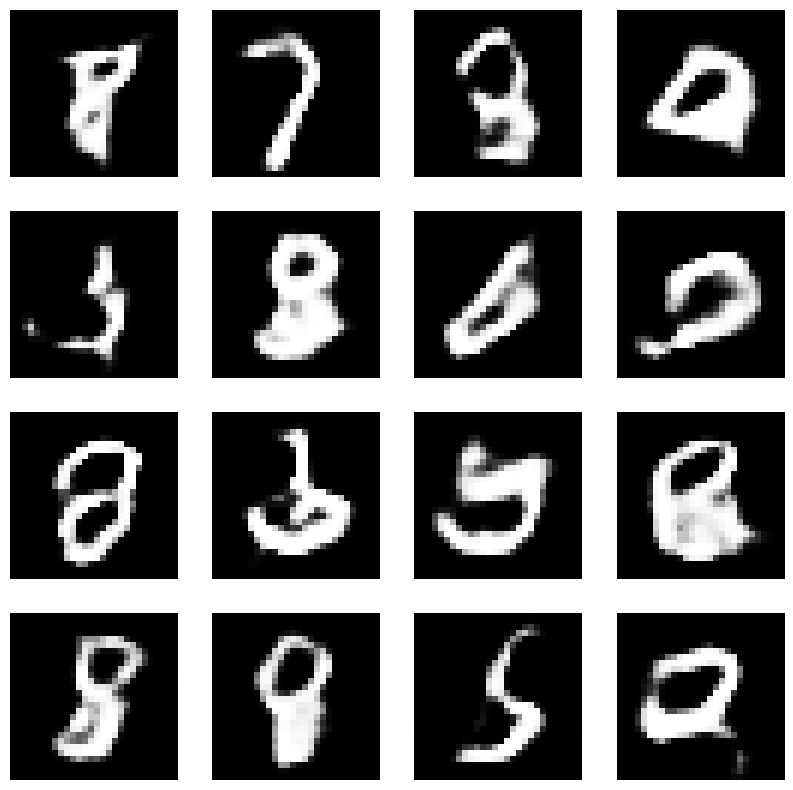

Epoch:  98


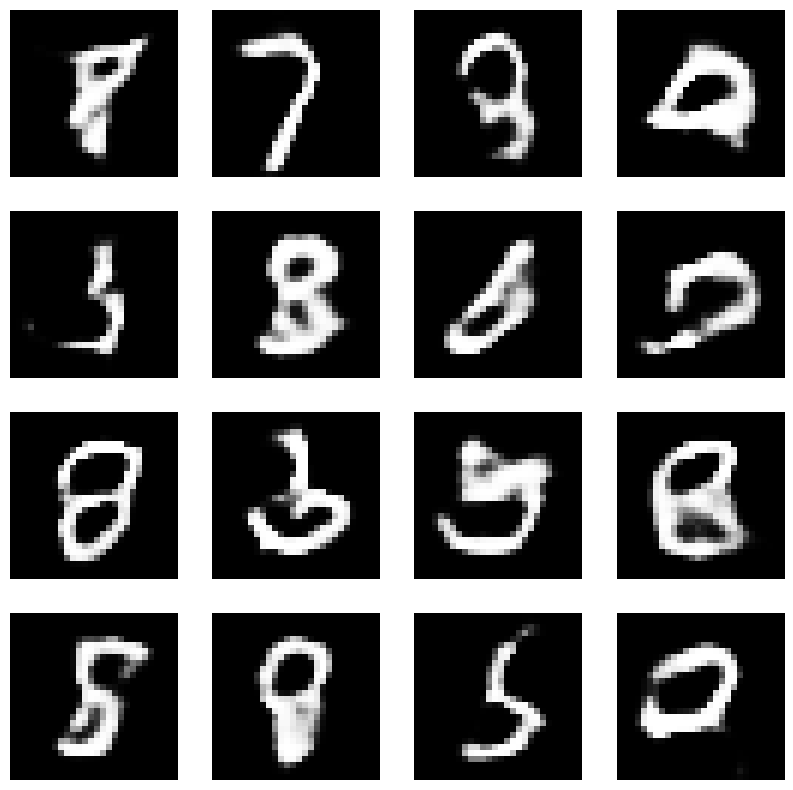

Epoch:  99


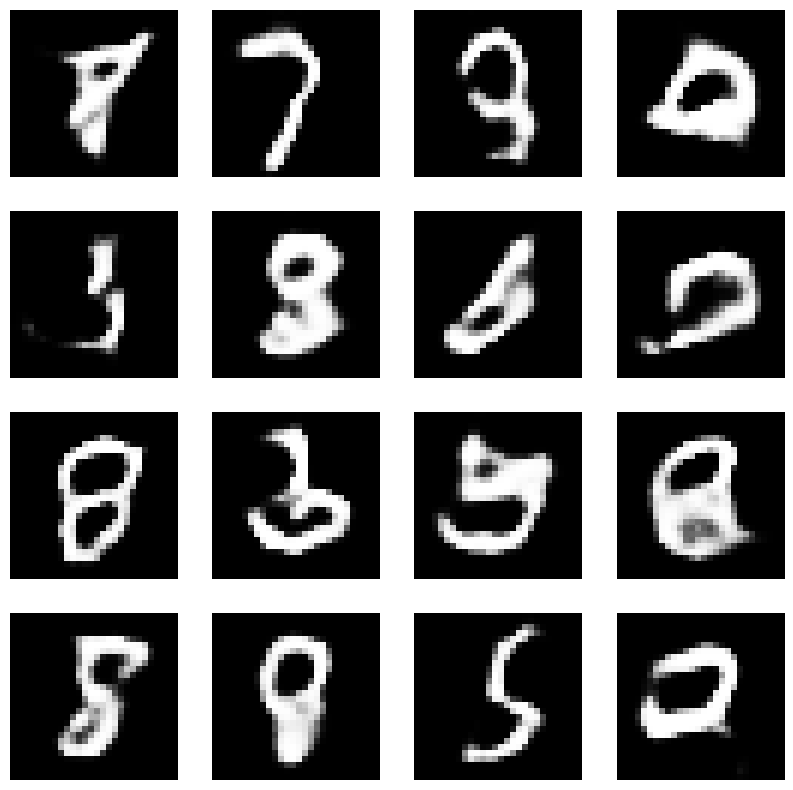

Epoch:  100


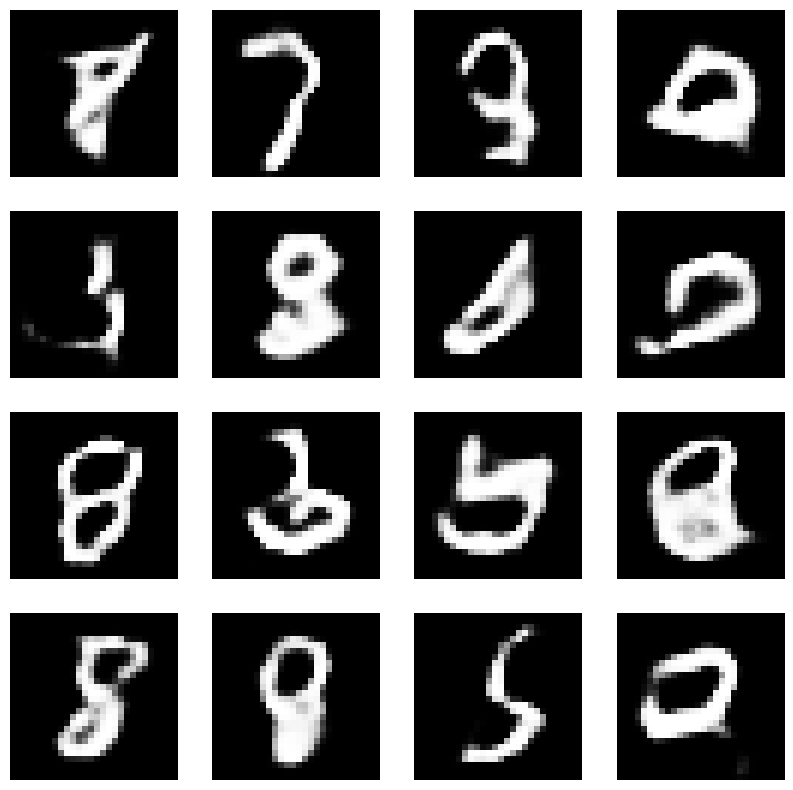

In [79]:
train(X_train,epochs,test_images)